# PROYECTO FINAL NLP: Análisis de Ofertas de Trabajo

**Grupo 3**

**Componentes**:

  -Sebastia Garcia, Sergio (Lider)

  -Dionis Ros, Alejandro

  -Lizzadro Pla, Adrian

  -Zhigarev, Ilia

**Fuente de datos**: Web Scraping (GetManfred.com)

**Objetivo principal**: Estimación del salario en función de la oferta

In [ ]:
# https://www.getmanfred.com/robots.txt
# https://www.getmanfred.com/sitemap-offers.xml

# https://www.getmanfred.com/ofertas-empleo/7991/factorlibre-senior-odoo-developer-may25
# https://www.getmanfred.com/ofertas-empleo/7406/mavelpoint-lead-frontend-engineer-may25

# Imports

In [ ]:
import requests
from bs4 import BeautifulSoup
from time import sleep
from random import uniform
import pandas as pd
import re
import numpy as np
import string
import spacy
import unicodedata
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LassoCV

# Web scraping

In [ ]:
sitemap_url = "https://www.getmanfred.com/sitemap-offers.xml"
response = requests.get(sitemap_url)
# print("response", response.content)

soup = BeautifulSoup(response.content, "xml")
urls = [loc.text for loc in soup.find_all("loc") if "/ofertas-empleo/" in loc.text]
print("urls", urls)

# Parsing
def parse_offer(url):
    BASE_URL = "https://www.getmanfred.com"
    full_url = url if url.startswith("http") else BASE_URL + url
    r = requests.get(full_url)
    s = BeautifulSoup(r.text, "html.parser")

    try:

        job_title = None

        h1 = s.find("h1").get_text(strip=True)
        print("h1", h1)
        if h1:
            job_title = h1


        salary = None
        h3 = s.find("h3", string=lambda text: text and "Salario" in text)
        if h3:
            parent_div = h3.find_parent("div")
            if parent_div:
                salary_span = parent_div.find("span")
                if salary_span:
                    salary = salary_span.get_text(strip=True).replace("\xa0", " ")

        skills_div = s.find("div", id="skills")
        skills_text = skills_div.get_text(" ", strip=True).replace("\xa0", " ") if skills_div else ""

        job_description_div = s.find("div", id="requisitos")
        job_description_text = job_description_div.get_text(" ", strip=True).replace("\xa0", " ") if job_description_div else ""


        location_div = s.find("div", id="donde")
        location_text = location_div.get_text(" ", strip=True).replace("\xa0", " ") if location_div else ""


        is_closed = "Oferta cerrada" in s.get_text()


        return {
            "url": full_url,
            "title": job_title,
            "salary": salary,
            "skills": skills_text,
            "job_description": job_description_text,
            "location": location_text,
            "is_offer_closed": is_closed
        }


    except Exception as e:
        print(f"error {url}: {e}")
        return None

print("ofertas=>", len(urls))

offers = []
for i, offer_url in enumerate(urls):
    print(f"Parsing {i+1}: {offer_url}")
    data = parse_offer(offer_url)
    if data:
        offers.append(data)
    # sleep(uniform(0.5, 1))

df_offers_raw = pd.DataFrame(offers)

urls ['https://www.getmanfred.com/ofertas-empleo/7991/factorlibre-senior-odoo-developer-may25', 'https://www.getmanfred.com/ofertas-empleo/7406/mavelpoint-lead-frontend-engineer-may25', 'https://www.getmanfred.com/ofertas-empleo/7990/abanca-net-developer-may25', 'https://www.getmanfred.com/ofertas-empleo/7989/dehn-php-drupal-developer-may25', 'https://www.getmanfred.com/ofertas-empleo/7956/signicat-java-developer-may25', 'https://www.getmanfred.com/ofertas-empleo/7922/naiz-fit-ai-engineer-abr25', 'https://www.getmanfred.com/ofertas-empleo/7888/salesql-devops-sre-abr25', 'https://www.getmanfred.com/ofertas-empleo/7887/eri-bancaire-tech-lead-frontend-abr25', 'https://www.getmanfred.com/ofertas-empleo/7854/saltoki-data-engineer-abr25', 'https://www.getmanfred.com/ofertas-empleo/7853/saltoki-bi-project-manager-abr25', 'https://www.getmanfred.com/ofertas-empleo/7820/bnp-senior-mainframe-specialist-abr25', 'https://www.getmanfred.com/ofertas-empleo/7751/driblab-team-lead-computer-visionml-ab

In [ ]:
print(df_offers_raw.loc[0, 'location'])

¿Dónde trabajarás?Remoto100%oPresencialMadridDonde quieras.La posición es100% remoto, aunque también tienes la opción de acudir alas oficinas de Madridde vez en cuando si te apetece el contacto en persona. En Factor Libre confían plenamente en eltrabajo en remoto(¡lo llevan practicando años!), por lo que tienen todo montado para que puedas trabajar desde casa o donde estés más cómodo, sin perder productividad o sentirte aislado.El equipo está distribuido geográficamente, pero eso no impide que haya mucha unión. De hecho, organizanencuentros presenciales trimestralesen Madrid para reunir a todo el equipo. Estas reuniones (de uno o dos días) sirven para trabajar juntos, hacerteambuilding, y pasarlo bien: desde sesiones para compartir conocimientos hasta cenas de equipo, juegos y actividades divertidas. ¡Así ponen cara a los avatares de Slack y refuerzan lazos! 😄 Remoto100%oPresencialMadridDonde quieras.La posición es100% remoto, aunque también tienes la opción de acudir alas oficinas de 

In [ ]:
df_offers_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              1295 non-null   object
 1   title            1295 non-null   object
 2   salary           1294 non-null   object
 3   skills           1295 non-null   object
 4   job_description  1295 non-null   object
 5   location         1295 non-null   object
 6   is_offer_closed  1295 non-null   bool  
dtypes: bool(1), object(6)
memory usage: 62.1+ KB


In [ ]:
df_offers_raw

url  \
0     https://www.getmanfred.com/ofertas-empleo/7991...   
1     https://www.getmanfred.com/ofertas-empleo/7406...   
2     https://www.getmanfred.com/ofertas-empleo/7990...   
3     https://www.getmanfred.com/ofertas-empleo/7989...   
4     https://www.getmanfred.com/ofertas-empleo/7956...   
...                                                 ...   
1290  https://www.getmanfred.com/ofertas-empleo/20/c...   
1291  https://www.getmanfred.com/ofertas-empleo/18/m...   
1292  https://www.getmanfred.com/ofertas-empleo/17/r...   
1293  https://www.getmanfred.com/ofertas-empleo/15/m...   
1294  https://www.getmanfred.com/ofertas-empleo/12/n...   

                       title     salary  \
0      Senior Odoo Developer    €30-40K   
1     Lead Frontend Engineer  Hasta€55K   
2             .Net Developer    €45-54K   
3     PHP (Drupal) Developer  Hasta€35K   
4             Java Developer    €35-45K   
...                      ...        ...   
1290           PHP Developer    €40-45K   
1291      Solution Architect  Hasta€80K   
1292           PHP Developer    €30-35K   
1293    Senior PHP Developer    €45-55K   
1294    Senior iOS Developer    €50-60K   

                                                 skills  \
0     Requisitos: - Experiencia sólida en Odoo: Al m...   
1     Por supuesto, el equipo de Mavelpoint también ...   
2     Sé que ya te estás enamorando del proyecto, pe...   
3     They are seeking someone who is passionate abo...   
4     Importantísimonivel fluído a nivel oral en ING...   
...                                                 ...   
1290  Buscan proactividad a tope, predisposición a v...   
1291  Ahora llega la carta a los Reyes Magos, pero n...   
1292  Tienen un monolito PHP + MySQL típico (un poco...   
1293  En marketgoo valoran más las actitudes que las...   
1294  Buscan mejorar como equipo y sumar talento por...   

                                        job_description  \
0     Para comenzar, me gustaría contarte un poquito...   
1     Antes de meternos en harina, ¿qué te parece si...   
2     ¿Creo que no hace faltan presentaciones, no? P...   
3     DEHN is a German company with over a century o...   
4     💥 Antes de nada, un poco de contexto: Allá por...   
...                                                 ...   
1290  Antes de entrar en materia, os contamosun poco...   
1291  Mindcurvnace en España y Alemania. Dos empresa...   
1292  En Ruukfy están creciendo sin financiación, la...   
1293  En marketgoo tenían todos los ingredientes nec...   
1294  Tendrás un gran impacto dentro de la compañía,...   

                                               location  is_offer_closed  
0     ¿Dónde trabajarás?Remoto100%oPresencialMadridD...            False  
1     ¿Dónde trabajarás?Remoto100%¡Desde donde a ti ...            False  
2     ¿Dónde trabajarás?Remoto100%oPresencialMadrid ...            False  
3     ¿Dónde trabajarás?Remoto100%You have the flexi...            False  
4     ¿Dónde trabajarás?Remoto100%oPresencialMadrid¡...            False  
...                                                 ...              ...  
1290  ¿Dónde trabajarás?Remoto100%¡Esta posición es ...             True  
1291  ¿Dónde trabajarás?Remoto100%La empresa cuenta ...             True  
1292  ¿Dónde trabajarás?Remoto100%Ruukfy es una empr...             True  
1293  ¿Dónde trabajarás?Remoto100%Algunas de las act...             True  
1294  ¿Dónde trabajarás?Remoto100%Tienen oficina en ...             True  

[1295 rows x 7 columns]

In [ ]:
# df_offers_raw.to_pickle('df_offers_raw.pkl')

# EDA y extracción de características

In [ ]:
df_offers_raw = pd.read_pickle('df_offers_raw.pkl')

In [ ]:
df_offers_raw.describe(include='all')

url               title  \
count                                                1296                1296   
unique                                               1296                 604   
top     https://www.getmanfred.com/ofertas-empleo/38/n...  Frontend Developer   
freq                                                    1                  43   

         salary                                             skills  \
count      1295                                               1296   
unique      185                                               1249   
top     €50-60K  ¿Qué piden? Necesitan gente que además de las ...   
freq         95                                                  4   

                                          job_description  \
count                                                1296   
unique                                               1215   
top     ¿Qué harás? La banca tradicional hace años que...   
freq                                                    4   

                                                 location is_offer_closed  
count                                                1296            1296  
unique                                                974               2  
top     ¿Dónde trabajarás? Presencial A Coruña y Telet...            True  
freq                                                    9            1265

In [ ]:
df_offers_raw['salary'].unique()

array(['€40-55K', '€30-40K', 'Hasta€55K', '€45-54K', 'Hasta€35K',
       '€35-45K', '€40-45K', '€50-60K', '€55-65K', 'Hasta€60K', '€45-50K',
       '€60-70K', 'Hasta€30K', '€55-70K', '€45-55K', '€33-45K', '€32-42K',
       '€40-50K', '€32-48K', 'Hasta€38K', '€35-42K', 'Hasta€80K', None,
       '€35-40K', '€60-75K', 'Hasta€45K', 'Hasta€40K', '€70-75K',
       '€30-35K', '€33-40K', '€20-25K', '€40-60K', 'Hasta€70K', '€50-55K',
       'Hasta€50K', '€25-30K', 'Hasta€27K', '€35-53K', '€70-80K',
       '€32-36K', 'Hasta€24K', '€40-48K', '€25-45K', '€25-28K',
       'Hasta€75K', '€80-90K', '€38-44K', 'Hasta€100K', '€48-55K',
       '€45-60K', '€79.2-114.4K', 'Hasta€110K', 'Hasta€65K', '€60-65K',
       '€20-24K', '€65-75K', '€70-100K', 'Hasta€42K', '€80-100K',
       '€30-37K', '€34-38K', '€28-33K', '€38-45K', '€39-43K', 'Hasta€95K',
       '€37-47K', '€60-80K', '€32-35K', '€35-60K', '€28-38K', '€33-36K',
       '€55-77K', '€40-47K', '€54-58K', '€35-50K', 'Hasta€48K', '€45-57K',
       'Hasta

In [ ]:
df_offers_raw['salary_int'] = (
    df_offers_raw['salary']
    .apply(lambda s: re.findall(r'[\d\.]+', s) if isinstance(s, str) else [])
    .apply(lambda nums: max([float(n) for n in nums]) if nums else np.nan)
    .apply(lambda x: int(round(x)) if not pd.isna(x) else np.nan)
)

In [ ]:
df_offers_raw['salary_int'].unique()

array([ 55.,  40.,  54.,  35.,  45.,  60.,  65.,  50.,  70.,  30.,  42.,
        48.,  38.,  80.,  nan,  75.,  25.,  27.,  53.,  36.,  24.,  28.,
        90.,  44., 100., 114., 110.,  37.,  33.,  43.,  95.,  47.,  77.,
        58.,  57.,  32.,  52.,  23.,  22.,  11.,  41.,  85.,  21.,  39.,
        46.,  56.,  29.,  62.,  59., 150., 130.,  91.,  26.,  34.,  69.,
        12.,  63.])

In [ ]:
df_offers_raw = df_offers_raw.dropna(subset=['salary_int'])

In [ ]:
df_offers_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1295 entries, 0 to 1295
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   url              1295 non-null   object 
 1   title            1295 non-null   object 
 2   salary           1295 non-null   object 
 3   skills           1295 non-null   object 
 4   job_description  1295 non-null   object 
 5   location         1295 non-null   object 
 6   is_offer_closed  1295 non-null   bool   
 7   salary_int       1295 non-null   float64
dtypes: bool(1), float64(1), object(6)
memory usage: 82.2+ KB


<function matplotlib.pyplot.grid(visible: 'bool | None' = None, which: "Literal['major', 'minor', 'both']" = 'major', axis: "Literal['both', 'x', 'y']" = 'both', **kwargs) -> 'None'>

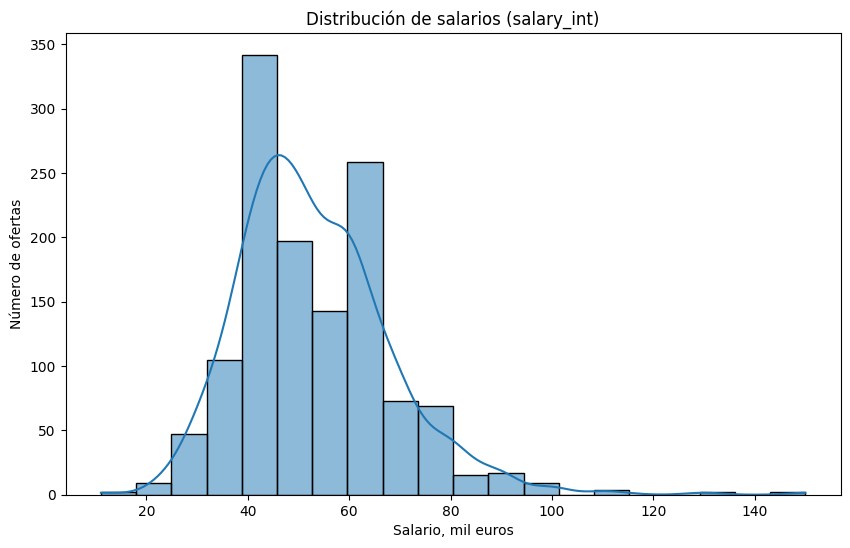

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_offers_raw['salary_int'], bins=20, kde=True)
plt.title('Distribución de salarios (salary_int)')
plt.xlabel('Salario, mil euros')
plt.ylabel('Número de ofertas')
plt.grid

In [ ]:
df_offers_raw['salary_quantile'] = pd.qcut(df_offers_raw['salary_int'], q=5, labels=[
    'Muy bajo', 'Bajo', 'Medio', 'Alto', 'Muy alto'
])


In [ ]:
pd.qcut(df_offers_raw['salary_int'], q=5).unique()

[(48.0, 55.0], (10.999, 40.0], (40.0, 48.0], (55.0, 65.0], (65.0, 150.0]]
Categories (5, interval[float64, right]): [(10.999, 40.0] < (40.0, 48.0] < (48.0, 55.0] <
                                           (55.0, 65.0] < (65.0, 150.0]]

In [ ]:
df_offers_raw

url  \
0     https://www.getmanfred.com/ofertas-empleo/8023...   
1     https://www.getmanfred.com/ofertas-empleo/7991...   
2     https://www.getmanfred.com/ofertas-empleo/7406...   
3     https://www.getmanfred.com/ofertas-empleo/7990...   
4     https://www.getmanfred.com/ofertas-empleo/7989...   
...                                                 ...   
1291  https://www.getmanfred.com/ofertas-empleo/20/c...   
1292  https://www.getmanfred.com/ofertas-empleo/18/m...   
1293  https://www.getmanfred.com/ofertas-empleo/17/r...   
1294  https://www.getmanfred.com/ofertas-empleo/15/m...   
1295  https://www.getmanfred.com/ofertas-empleo/12/n...   

                       title     salary  \
0      Java Backend Engineer    €40-55K   
1      Senior Odoo Developer    €30-40K   
2     Lead Frontend Engineer  Hasta€55K   
3             .Net Developer    €45-54K   
4     PHP (Drupal) Developer  Hasta€35K   
...                      ...        ...   
1291           PHP Developer    €40-45K   
1292      Solution Architect  Hasta€80K   
1293           PHP Developer    €30-35K   
1294    Senior PHP Developer    €45-55K   
1295    Senior iOS Developer    €50-60K   

                                                 skills  \
0     ¿Qué piden? A estas alturas seguro que ya tend...   
1     ¿Qué piden? Requisitos : - Experiencia sólida ...   
2     ¿Qué piden? Por supuesto, el equipo de Mavelpo...   
3     ¿Qué piden? Sé que ya te estás enamorando del ...   
4     ¿Qué piden? They are seeking someone who is pa...   
...                                                 ...   
1291  ¿Qué piden? Buscan proactividad a tope, predis...   
1292  ¿Qué piden? Ahora llega la carta a los Reyes M...   
1293  ¿Qué piden? Tienen un monolito PHP + MySQL típ...   
1294  ¿Qué piden? En marketgoo valoran más las actit...   
1295  ¿Qué piden? Buscan mejorar como equipo y sumar...   

                                        job_description  \
0     ¿Qué harás? 🤔 Grandes preguntas ¿De dónde vien...   
1     ¿Qué harás? Para comenzar, me gustaría contart...   
2     ¿Qué harás? Antes de meternos en harina, ¿qué ...   
3     ¿Qué harás? ¿Creo que no hace faltan presentac...   
4     ¿Qué harás? DEHN is a German company with over...   
...                                                 ...   
1291  ¿Qué harás? Antes de entrar en materia, os con...   
1292  ¿Qué harás? Mindcurv nace en España y Alemania...   
1293  ¿Qué harás? En Ruukfy están creciendo sin fina...   
1294  ¿Qué harás? En marketgoo tenían todos los ingr...   
1295  ¿Qué harás? Tendrás un gran impacto dentro de ...   

                                               location  is_offer_closed  \
0     ¿Dónde trabajarás? Remoto 100 % ¡Esta posición...            False   
1     ¿Dónde trabajarás? Remoto 100 % o Presencial M...            False   
2     ¿Dónde trabajarás? Remoto 100 % ¡Desde donde a...            False   
3     ¿Dónde trabajarás? Remoto 100 % o Presencial M...            False   
4     ¿Dónde trabajarás? Remoto 100 % You have the f...            False   
...                                                 ...              ...   
1291  ¿Dónde trabajarás? Remoto 100 % ¡Esta posición...             True   
1292  ¿Dónde trabajarás? Remoto 100 % La empresa cue...             True   
1293  ¿Dónde trabajarás? Remoto 100 % Ruukfy es una ...             True   
1294  ¿Dónde trabajarás? Remoto 100 % Algunas de las...             True   
1295  ¿Dónde trabajarás? Remoto 100 % Tienen oficina...             True   

      salary_int salary_quantile  
0           55.0           Medio  
1           40.0        Muy bajo  
2           55.0           Medio  
3           54.0           Medio  
4           35.0        Muy bajo  
...          ...             ...  
1291        45.0            Bajo  
1292        80.0        Muy alto  
1293        35.0        Muy bajo  
1294        55.0           Medio  
1295        60.0            Alto  

[1295 rows x 9 columns]

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=3c1fa5f412722b2176bd8e97b5881cfe675cfa0c29a31f83d26e6b7f11e4cf9e
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
from langdetect import detect
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

df_offers_raw['lang'] = df_offers_raw['skills'].apply(detect_language)


In [ ]:
df_offers_es = df_offers_raw[df_offers_raw['lang'] == 'es'].copy()

In [ ]:
df_offers_es.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1250 entries, 0 to 1295
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   url              1250 non-null   object  
 1   title            1250 non-null   object  
 2   salary           1250 non-null   object  
 3   skills           1250 non-null   object  
 4   job_description  1250 non-null   object  
 5   location         1250 non-null   object  
 6   is_offer_closed  1250 non-null   bool    
 7   salary_int       1250 non-null   float64 
 8   salary_quantile  1250 non-null   category
 9   lang             1250 non-null   object  
dtypes: bool(1), category(1), float64(1), object(7)
memory usage: 90.5+ KB


In [ ]:
# Extraer año de la oferta
df_offers_es['year'] = df_offers_es['url'].str[-2:]

In [ ]:
df_offers_es

url  \
0     https://www.getmanfred.com/ofertas-empleo/8023...   
1     https://www.getmanfred.com/ofertas-empleo/7991...   
2     https://www.getmanfred.com/ofertas-empleo/7406...   
3     https://www.getmanfred.com/ofertas-empleo/7990...   
5     https://www.getmanfred.com/ofertas-empleo/7956...   
...                                                 ...   
1291  https://www.getmanfred.com/ofertas-empleo/20/c...   
1292  https://www.getmanfred.com/ofertas-empleo/18/m...   
1293  https://www.getmanfred.com/ofertas-empleo/17/r...   
1294  https://www.getmanfred.com/ofertas-empleo/15/m...   
1295  https://www.getmanfred.com/ofertas-empleo/12/n...   

                       title     salary  \
0      Java Backend Engineer    €40-55K   
1      Senior Odoo Developer    €30-40K   
2     Lead Frontend Engineer  Hasta€55K   
3             .Net Developer    €45-54K   
5             Java Developer    €35-45K   
...                      ...        ...   
1291           PHP Developer    €40-45K   
1292      Solution Architect  Hasta€80K   
1293           PHP Developer    €30-35K   
1294    Senior PHP Developer    €45-55K   
1295    Senior iOS Developer    €50-60K   

                                                 skills  \
0     ¿Qué piden? A estas alturas seguro que ya tend...   
1     ¿Qué piden? Requisitos : - Experiencia sólida ...   
2     ¿Qué piden? Por supuesto, el equipo de Mavelpo...   
3     ¿Qué piden? Sé que ya te estás enamorando del ...   
5     ¿Qué piden? Importantísimo nivel fluído a nive...   
...                                                 ...   
1291  ¿Qué piden? Buscan proactividad a tope, predis...   
1292  ¿Qué piden? Ahora llega la carta a los Reyes M...   
1293  ¿Qué piden? Tienen un monolito PHP + MySQL típ...   
1294  ¿Qué piden? En marketgoo valoran más las actit...   
1295  ¿Qué piden? Buscan mejorar como equipo y sumar...   

                                        job_description  \
0     ¿Qué harás? 🤔 Grandes preguntas ¿De dónde vien...   
1     ¿Qué harás? Para comenzar, me gustaría contart...   
2     ¿Qué harás? Antes de meternos en harina, ¿qué ...   
3     ¿Qué harás? ¿Creo que no hace faltan presentac...   
5     ¿Qué harás? 💥 Antes de nada, un poco de contex...   
...                                                 ...   
1291  ¿Qué harás? Antes de entrar en materia, os con...   
1292  ¿Qué harás? Mindcurv nace en España y Alemania...   
1293  ¿Qué harás? En Ruukfy están creciendo sin fina...   
1294  ¿Qué harás? En marketgoo tenían todos los ingr...   
1295  ¿Qué harás? Tendrás un gran impacto dentro de ...   

                                               location  is_offer_closed  \
0     ¿Dónde trabajarás? Remoto 100 % ¡Esta posición...            False   
1     ¿Dónde trabajarás? Remoto 100 % o Presencial M...            False   
2     ¿Dónde trabajarás? Remoto 100 % ¡Desde donde a...            False   
3     ¿Dónde trabajarás? Remoto 100 % o Presencial M...            False   
5     ¿Dónde trabajarás? Remoto 100 % o Presencial M...            False   
...                                                 ...              ...   
1291  ¿Dónde trabajarás? Remoto 100 % ¡Esta posición...             True   
1292  ¿Dónde trabajarás? Remoto 100 % La empresa cue...             True   
1293  ¿Dónde trabajarás? Remoto 100 % Ruukfy es una ...             True   
1294  ¿Dónde trabajarás? Remoto 100 % Algunas de las...             True   
1295  ¿Dónde trabajarás? Remoto 100 % Tienen oficina...             True   

      salary_int salary_quantile lang year  
0           55.0           Medio   es   25  
1           40.0        Muy bajo   es   25  
2           55.0           Medio   es   25  
3           54.0           Medio   es   25  
5           45.0            Bajo   es   25  
...          ...             ...  ...  ...  
1291        45.0            Bajo   es   21  
1292        80.0        Muy alto   es   21  
1293        35.0        Muy bajo   es   21  
1294        55.0           Medio   es   21  


In [ ]:
df_offers_es.describe(include='all')

url               title  \
count                                                1250                1250   
unique                                               1250                 587   
top     https://www.getmanfred.com/ofertas-empleo/12/n...  Frontend Developer   
freq                                                    1                  43   
mean                                                  NaN                 NaN   
std                                                   NaN                 NaN   
min                                                   NaN                 NaN   
25%                                                   NaN                 NaN   
50%                                                   NaN                 NaN   
75%                                                   NaN                 NaN   
max                                                   NaN                 NaN   

         salary                                             skills  \
count      1250                                               1250   
unique      180                                               1203   
top     €40-50K  ¿Qué piden? Necesitan gente que además de las ...   
freq         93                                                  4   
mean        NaN                                                NaN   
std         NaN                                                NaN   
min         NaN                                                NaN   
25%         NaN                                                NaN   
50%         NaN                                                NaN   
75%         NaN                                                NaN   
max         NaN                                                NaN   

                                          job_description  \
count                                                1250   
unique                                               1170   
top     ¿Qué harás? En Ebolution son buenos en e-comme...   
freq                                                    4   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                                 location is_offer_closed  \
count                                                1250            1250   
unique                                                938               2   
top     ¿Dónde trabajarás? Remoto 100 % ¡Desde donde q...            True   
freq                                                    9            1220   
mean                                                  NaN             NaN   
std                                                   NaN             NaN   
min                                                   NaN             NaN   
25%                                                   NaN             NaN   
50%                                                   NaN             NaN   
75%                                                   NaN             NaN   
max                                                   NaN             NaN   

         salary_int salary_quantile  lang  year  
count   1250.000000            1250  1250  1250  
unique          NaN               5     1     6  
top             NaN           Medio    es    22  
freq            NaN             300  1250   374  
mean      52.771200             NaN   NaN   NaN  
std       15.038583             NaN   NaN   NaN  
min       11.000000             NaN   NaN   NaN  
25%       42.000000             NaN   NaN   NaN  
50%       50.000000             NaN   NaN   NaN  
75%       60.000000             NaN   NaN   NaN  
max      150.000000             

In [ ]:
df_offers_es['skills_list'] = df_offers_es['skills'].str.split(', ')
df_exploded = df_offers_es.explode('skills_list')
df_exploded['skills_list'].value_counts().head(20)

skills_list
pero no te preocupes                                                                                                                                           35
CSS                                                                                                                                                            29
¿Qué piden? Seguro que a estas alturas te mueres por saber qué te van a pedir y si habrá match o no con tus skills. Pues bien                                  27
¿Qué piden? Ahora llega la carta a los Reyes Magos                                                                                                             25
al menos                                                                                                                                                       22
Kubernetes                                                                                                                                                     22
Docker                                                                                                                                                         21
Angular                                                                                                                                                        19
a los Reyes Magos 👑👑👑                                                                                                                                          19
pero también potencial                                                                                                                                         18
déjame que te desvele el misterio y te cuente que en el equipo son bastante flexibles y se enfocan en encontrar una persona que tenga conocimientos sólidos    17
además                                                                                                                                                         17
React                                                                                                                                                          16
monitorización                                                                                                                                                 16
Salesforce                                                                                                                                                     16
de hecho                                                                                                                                                       15
ECS                                                                                                                                                            15
testeo                                                                                                                                                         14
caching                                                                                                                                                        14
Python                                                                                                                                                         14
Name: count, dtype: int64

In [ ]:
df_offers_es['is_offer_closed'].value_counts()


is_offer_closed
True     1220
False      30
Name: count, dtype: int64

In [ ]:
df_offers_es['salary_quantile'].value_counts().sort_index()


salary_quantile
Muy bajo    287
Bajo        231
Medio       300
Alto        257
Muy alto    175
Name: count, dtype: int64

In [ ]:
df_offers_es['title'].value_counts().head(10)


title
Frontend Developer           43
PHP Developer                36
Senior Frontend Developer    27
Data Engineer                22
Senior Backend Developer     22
Java Backend Developer       21
Senior Java Developer        19
Java Developer               19
Backend Developer            18
SysAdmin                     18
Name: count, dtype: int64

In [ ]:
df_offers_es['year'].value_counts().sort_index()

year
21    153
22    374
23    332
24    273
25    113
er      5
Name: count, dtype: int64

In [ ]:
def prepare_wordcloud_corpus(data: pd.core.series.Series) -> str:
  corpus = ""
  for entry in data:
    tokens = entry.split()
    corpus += " ".join(tokens)+" "
  return corpus

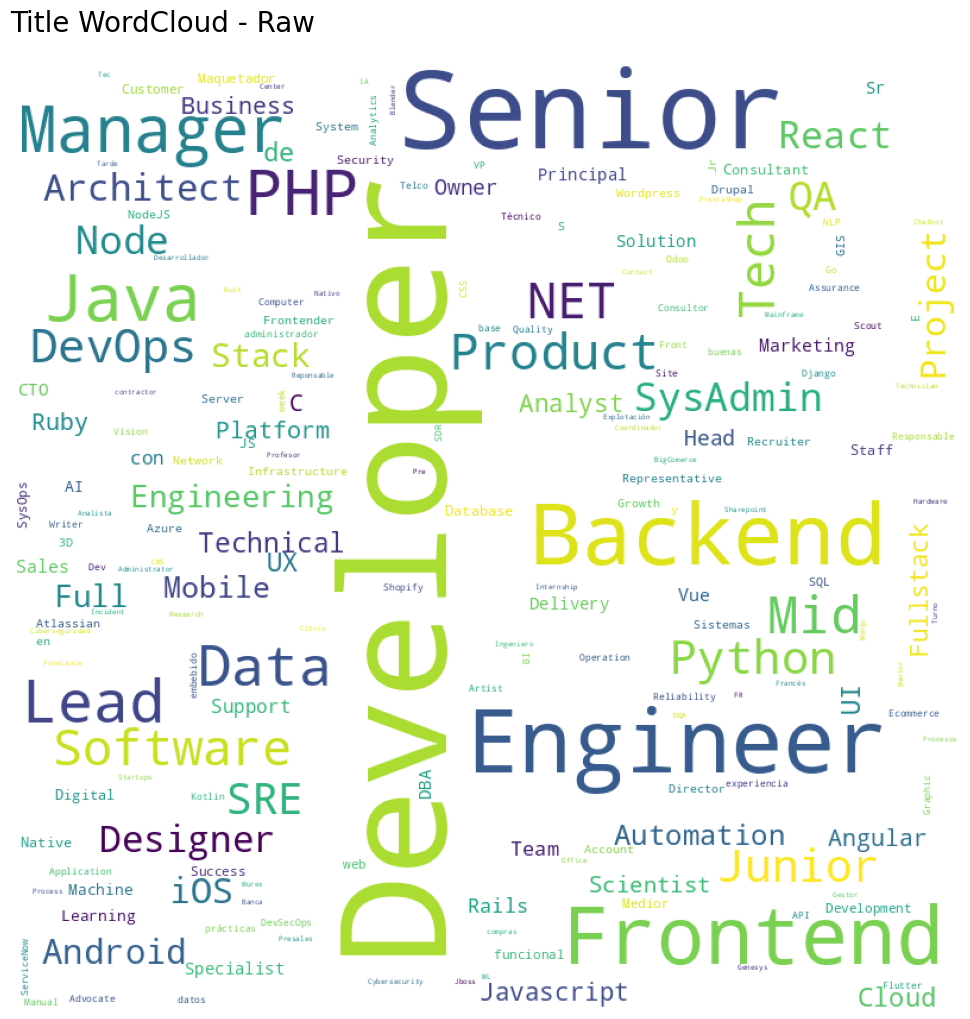

In [ ]:
# --- WORDCLOUD de titulos ---

wordcloud = WordCloud(width=800, height=800,
                      background_color="white",
                      min_font_size=2, collocations=False).generate(prepare_wordcloud_corpus(df_offers_es['title']))

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.title("Title WordCloud - Raw", loc="left", fontsize=20, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

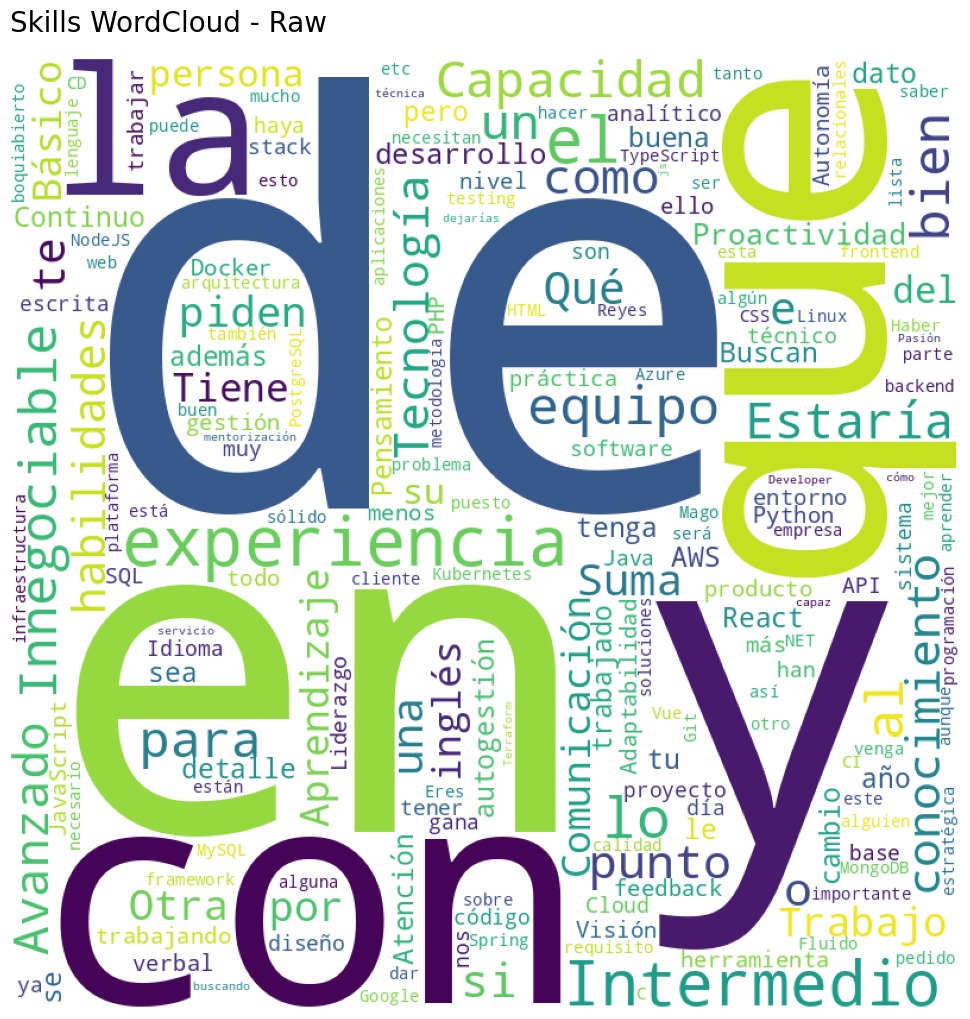

In [ ]:
# --- WORDCLOUD de skills ---

wordcloud = WordCloud(width=800, height=800,
                      background_color="white",
                      min_font_size=2, collocations=False).generate(prepare_wordcloud_corpus(df_offers_es['skills']))

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.title("Skills WordCloud - Raw", loc="left", fontsize=20, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

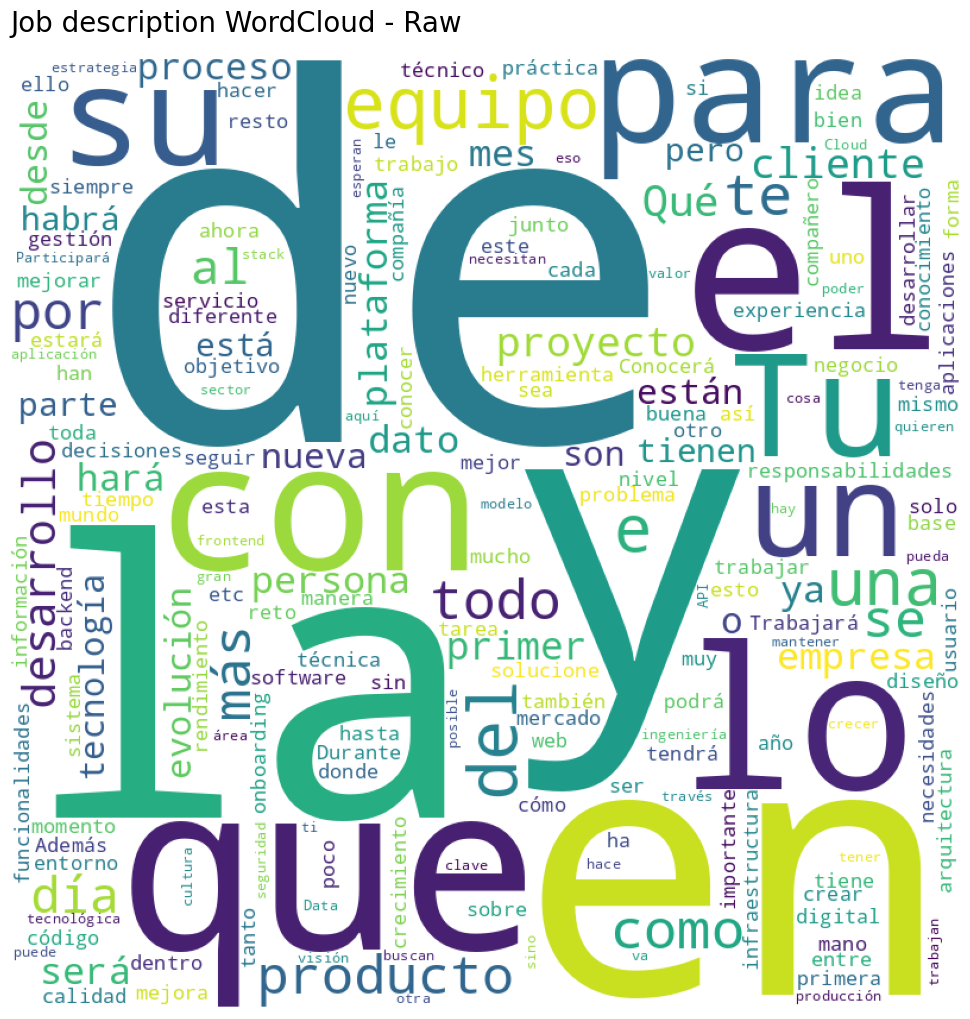

In [ ]:
# --- WORDCLOUD de job_description ---

wordcloud = WordCloud(width=800, height=800,
                      background_color="white",
                      min_font_size=2, collocations=False).generate(prepare_wordcloud_corpus(df_offers_es['job_description']))

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.title("Job description WordCloud - Raw", loc="left", fontsize=20, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

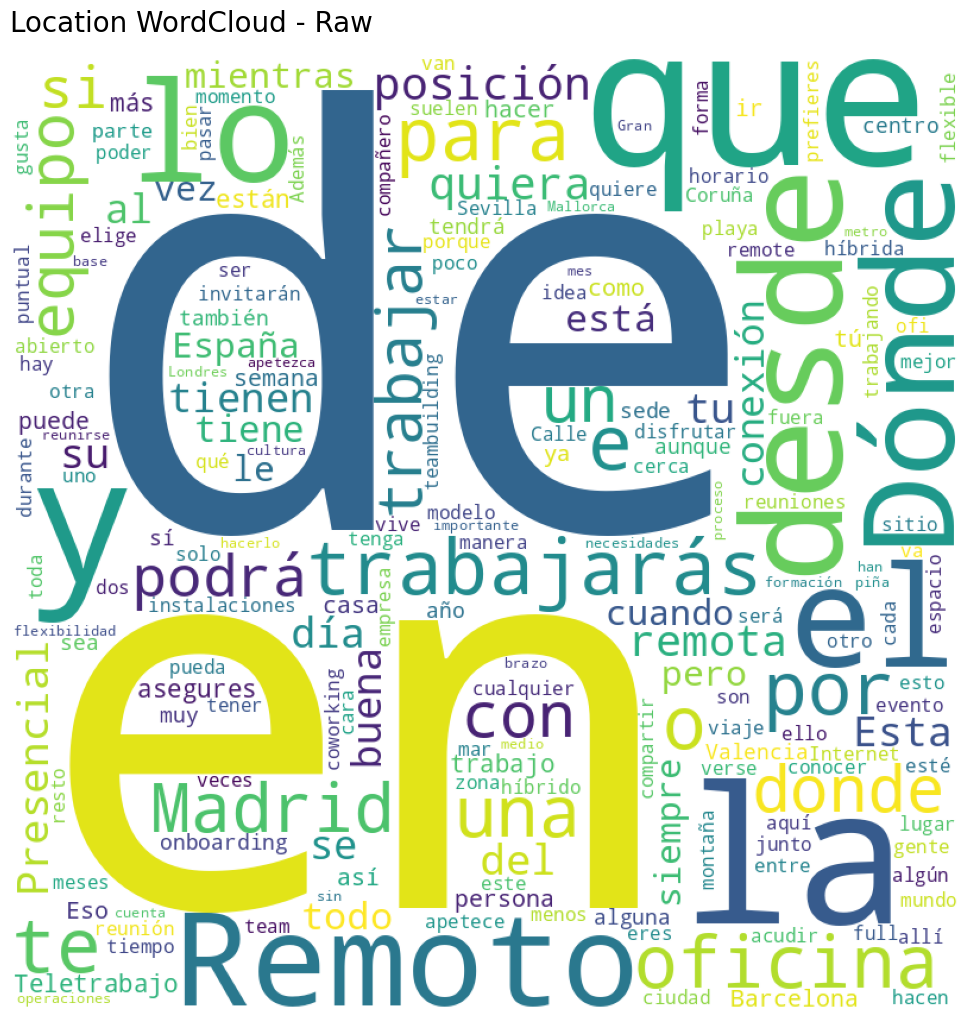

In [ ]:
# --- WORDCLOUD de location ---

wordcloud = WordCloud(width=800, height=800,
                      background_color="white",
                      min_font_size=2, collocations=False).generate(prepare_wordcloud_corpus(df_offers_es['location']))

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.title("Location WordCloud - Raw", loc="left", fontsize=20, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

# Preprocesado

En cuanto al preprocesado realizado a los distintos textos del corpus, se ha implementado la función ```clean_data```, junto con las funciones auxiliares ```unaccent_text``` y ```lemmatize_text```.

Comenzando por la función ```lemmatize_text```, esta toma como entrada una cadena de caracteres, la cual se tokeniza y devuelve como resultado una lista con los lemas de cada token de la cadena, si existe un lema para el token correspondiente(```token.lemma_ != ''```).

En cuanto a la función ```unaccent_text```, esta toma como entrada una cadena de caracteres. En esta se crea un mapeado (```str.maketrans```) de las distintas vocales acentuadas a su versión sin acentuar y se aplica el mapeado al texto de entrada mediante la función ```translate```.

Por último, tenemos la función principal para el preprocesado del corpus, ```clean_text```. Esta función toma como entrada una cadena de caracteres y los *flags* correspondientes a cada paso de preprocesado a aplicar. Como base, el modelo aplica una limpieza de signos de puntuación y espacios mediante expresiones regulares, además de pasar a minúsculas los textos y eliminar los emoticonos con la función ```replace_emoji``` de la librería ```emoji```. A continuación, aplica la correspondiente limpieza de acentos y lematización, si se ha seleccionado, a partir de las funciones explicadas anteriormente. Por último, se eliminan las *stopwords* del corpus, si se ha indicado aplicar dicho procesado. Como resultado, devuelve una cadena de caracteres resultado de aplicar al texto de entrada el preprocesado.

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
!python -m spacy download es_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 3.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load("es_core_news_lg")

pat_punct  = re.compile('[{}]'.format(re.escape(string.punctuation)))

# Eliminar tildes
def unaccent_text(texto: str) -> str:
    changes = str.maketrans(
        'áéíóúüÁÉÍÓÚÜ',
        'aeiouuAEIOUU'
    )
    return texto.translate(changes)

# Lematizar texto
def lemmatize_text(text: str) -> list:
  return [token.lemma_ for token in nlp(text) if token.lemma_ != '']


def clean_text(text: str, remove_stopwords: bool = True,
               remove_accents: bool = True, lemmatize: bool = True) -> str:

  if text is None:
        raise ValueError("Input text cannot be None")

  # Quitar emojis
  text = emoji.replace_emoji(text)
  text = re.sub(r'\s+', ' ', text).strip()

  # Tokenizar texto
  doc = nlp(text)

  # Quitar puntuación, espacios
  # Pasar a minúscula
  tokens = [
      re.sub(pat_punct, '', t.lower_)
      for t in doc if not t.is_punct and not t.is_space
  ]

  # Quitar acentos
  if remove_accents:
    tokens = [unaccent_text(t) for t in tokens]

  # Lematizar
  if lemmatize:
    tokens = lemmatize_text(' '.join(tokens))

  doc_filtered = nlp(' '.join(tokens))

  # Quitar stopwords
  if remove_stopwords:
    tokens = [t.text for t in doc_filtered if not t.is_stop]
  else:
    tokens = [t.text for t in doc_filtered]

  return ' '.join(tokens).strip()

## *clean_text* Unit Testing

In [ ]:
# --- UNIT TESTING ---
import unittest

class TestCleanText(unittest.TestCase):

    def test_normal_text(self):
        text = "¡Hola mundo! 😊"
        result = clean_text(text)
        self.assertEqual(result, "hola mundo")

    def test_empty_string(self):
        self.assertEqual(clean_text(""), "")

    def test_only_emojis_and_punct(self):
        result = clean_text("😂😂!!!")
        self.assertEqual(result, "")

    def test_none_input(self):
        with self.assertRaises(ValueError):
            clean_text(None)

    def test_lemmatization_only(self):
        result = clean_text("corriendo saltando", lemmatize=True, remove_stopwords=False, remove_accents=False)
        self.assertIn("correr", result)
        self.assertIn("saltar", result)

    def test_without_stopwords(self):
        result = clean_text("el gato y el perro", remove_stopwords=True)
        self.assertEqual(result, "gato perro")

    def test_with_stopwords(self):
        result = clean_text("el gato y el perro", remove_stopwords=False)
        self.assertEqual(result, "el gato y el perro")

    def test_without_lemmatization(self):
        result = clean_text("corriendo", lemmatize=False, remove_stopwords=False, remove_accents=False)
        self.assertIn("corriendo", result)

# Ejecutar los tests
unittest.main(argv=[''], verbosity=2, exit=False)


test_empty_string (__main__.TestCleanText.test_empty_string) ... ok
test_lemmatization_only (__main__.TestCleanText.test_lemmatization_only) ... ok
test_none_input (__main__.TestCleanText.test_none_input) ... ok
test_normal_text (__main__.TestCleanText.test_normal_text) ... ok
test_only_emojis_and_punct (__main__.TestCleanText.test_only_emojis_and_punct) ... ok
test_with_stopwords (__main__.TestCleanText.test_with_stopwords) ... ok
test_without_lemmatization (__main__.TestCleanText.test_without_lemmatization) ... ok
test_without_stopwords (__main__.TestCleanText.test_without_stopwords) ... ok

----------------------------------------------------------------------
Ran 8 tests in 0.141s

OK




---



## Aplicar preprocesado

In [ ]:
args = {"remove_stopwords":True, "remove_accents":True, "lemmatize":True}

df_offers_es['skills_clean'] = df_offers_es['skills'].apply(clean_text,
                                                            remove_stopwords=args.get("remove_stopwords"),
                                                            remove_accents=args.get("remove_accents"),
                                                            lemmatize=args.get("lemmatize"))

df_offers_es['job_description_clean'] = df_offers_es['job_description'].apply(clean_text,
                                                            remove_stopwords=args.get("remove_stopwords"),
                                                            remove_accents=args.get("remove_accents"),
                                                            lemmatize=args.get("lemmatize"))

df_offers_es['location_clean'] = df_offers_es['location'].apply(clean_text,
                                                            remove_stopwords=args.get("remove_stopwords"),
                                                            remove_accents=args.get("remove_accents"),
                                                            lemmatize=args.get("lemmatize"))

df_offers_es['title_clean'] = df_offers_es['title'].apply(clean_text,
                                                            remove_stopwords=False,
                                                            remove_accents=True,
                                                            lemmatize=False)

In [ ]:
df_offers_es.head(3)

url                   title  \
0  https://www.getmanfred.com/ofertas-empleo/8023...   Java Backend Engineer   
1  https://www.getmanfred.com/ofertas-empleo/7991...   Senior Odoo Developer   
2  https://www.getmanfred.com/ofertas-empleo/7406...  Lead Frontend Engineer   

      salary                                             skills  \
0    €40-55K  ¿Qué piden? A estas alturas seguro que ya tend...   
1    €30-40K  ¿Qué piden? Requisitos : - Experiencia sólida ...   
2  Hasta€55K  ¿Qué piden? Por supuesto, el equipo de Mavelpo...   

                                     job_description  \
0  ¿Qué harás? 🤔 Grandes preguntas ¿De dónde vien...   
1  ¿Qué harás? Para comenzar, me gustaría contart...   
2  ¿Qué harás? Antes de meternos en harina, ¿qué ...   

                                            location  is_offer_closed  \
0  ¿Dónde trabajarás? Remoto 100 % ¡Esta posición...            False   
1  ¿Dónde trabajarás? Remoto 100 % o Presencial M...            False   
2  ¿Dónde trabajarás? Remoto 100 % ¡Desde donde a...            False   

   salary_int salary_quantile lang year  \
0        55.0           Medio   es   25   
1        40.0        Muy bajo   es   25   
2        55.0           Medio   es   25   

                                        skills_clean  \
0  pedir altura seguro tendrar idea pedir buscar ...   
1  pedir requisito experiencia solido odoo 5 año ...   
2  pedir equipo mavelpoint pasar particular carta...   

                               job_description_clean  \
0  harar pregunta venir dejar recorrido historia ...   
1  harar comenzar gustariar contar poquito histor...   
2  harar meter harina parecer contar contexto mav...   

                                      location_clean             title_clean  
0  trabajaras remoto 100 posicion 100 remoto ests...   java backend engineer  
1  trabajaras remoto 100 presencial madrid querer...   senior odoo developer  
2  trabajaras remoto 100 apetecer posicion 100 re...  lead frontend engineer

In [ ]:
# # Save to .pkl
# with open("df_offers_clean_sw+acc+lemm.pkl", "wb") as f:
#   pickle.dump((df_offers_es, args), f)

In [ ]:
# Carga de fichero .pkl.
# 'args_clean_text' son metadatos para recuperar el preprocesado aplicado
with open("df_offers_clean_sw+acc.pkl", "rb") as f:
  df_offers_es, args_clean_text = pickle.load(f)

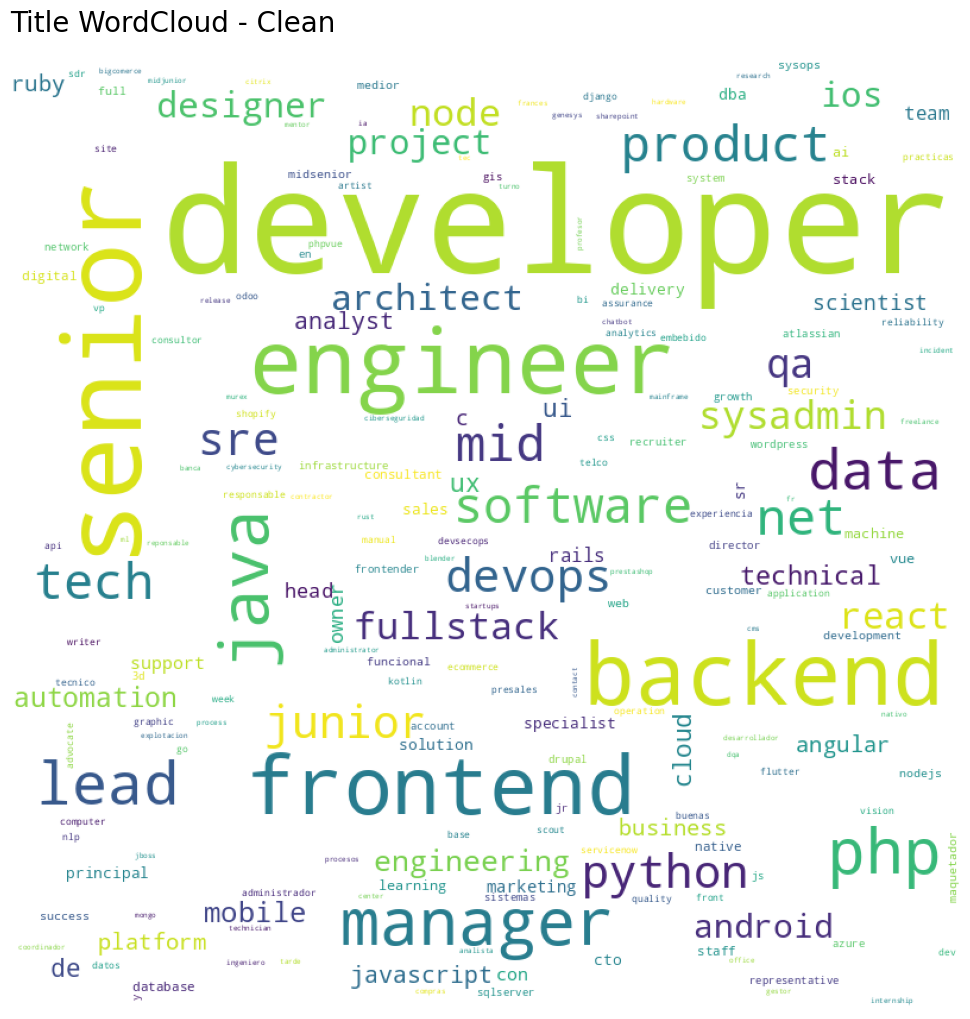

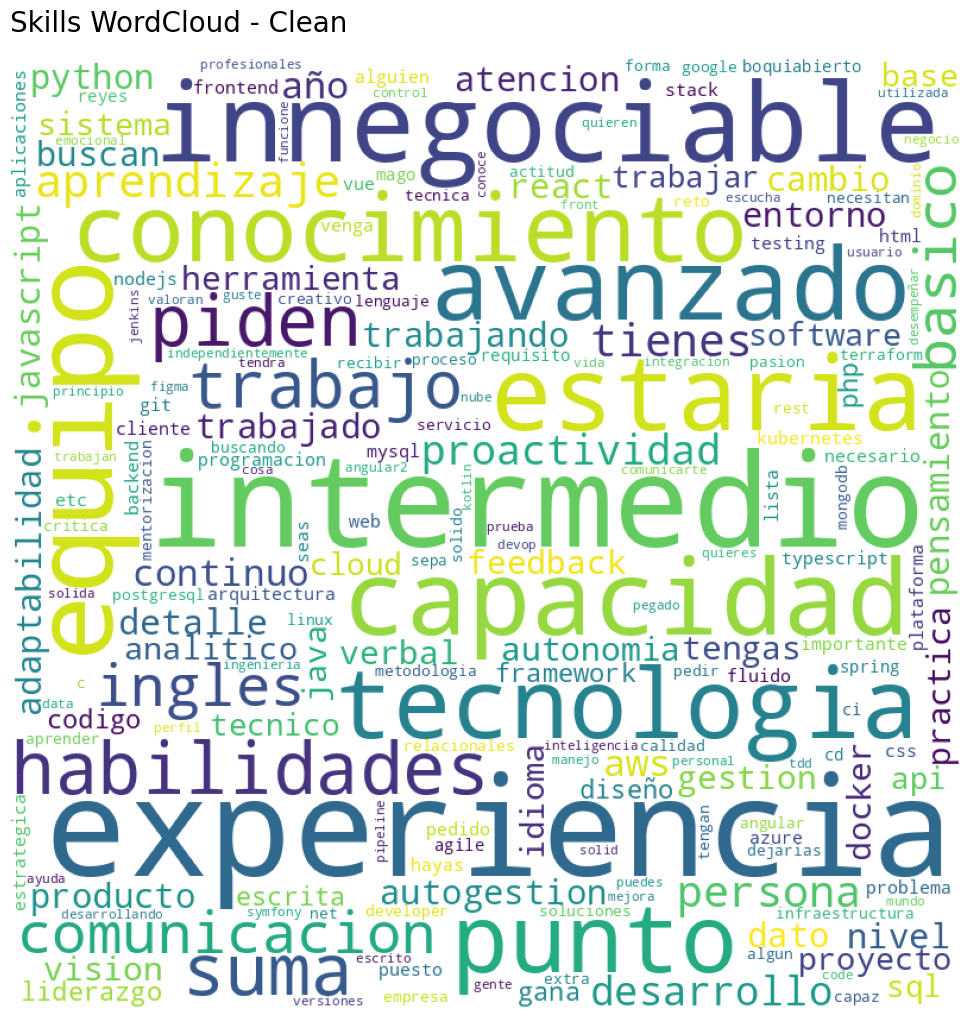

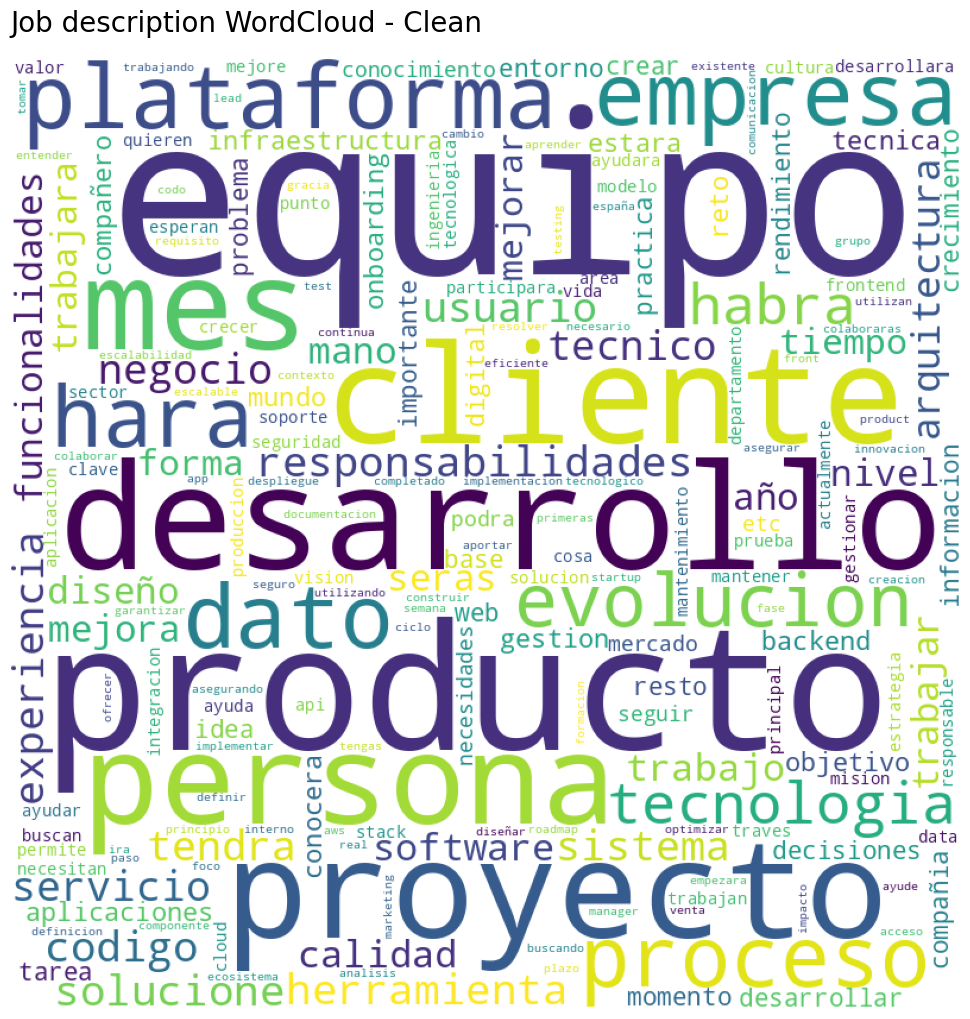

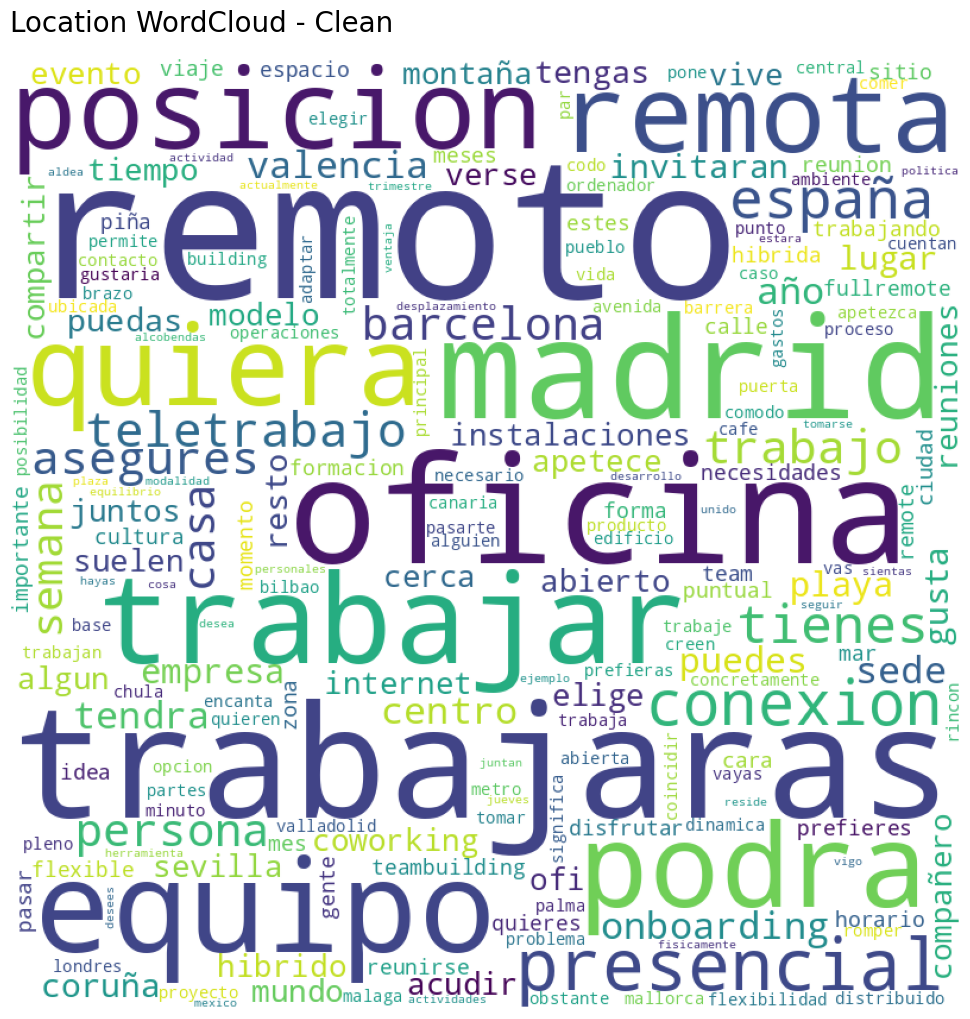

In [ ]:
# --- WORDCLOUD de titulos ---

wordcloud = WordCloud(width=800, height=800,
                      background_color="white",
                      min_font_size=2, collocations=False).generate(prepare_wordcloud_corpus(df_offers_es['title_clean']))

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.title("Title WordCloud - Clean", loc="left", fontsize=20, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

print()

# --- WORDCLOUD de skills ---

wordcloud = WordCloud(width=800, height=800,
                      background_color="white",
                      min_font_size=2, collocations=False).generate(prepare_wordcloud_corpus(df_offers_es['skills_clean']))

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.title("Skills WordCloud - Clean", loc="left", fontsize=20, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

print()

# --- WORDCLOUD de job_description ---

wordcloud = WordCloud(width=800, height=800,
                      background_color="white",
                      min_font_size=2, collocations=False).generate(prepare_wordcloud_corpus(df_offers_es['job_description_clean']))

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.title("Job description WordCloud - Clean", loc="left", fontsize=20, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

print()

# --- WORDCLOUD de location ---

wordcloud = WordCloud(width=800, height=800,
                      background_color="white",
                      min_font_size=2, collocations=False).generate(prepare_wordcloud_corpus(df_offers_es['location_clean']))

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.title("Location WordCloud - Clean", loc="left", fontsize=20, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
df_offers_es['full_description'] = df_offers_es['title_clean'] + ' ' + df_offers_es['skills_clean'] + ' ' + df_offers_es['job_description_clean'] + ' ' + df_offers_es['location_clean']

In [ ]:
df_offers_es[['title','salary','is_offer_closed','lang','year']].describe(include='all')

title   salary is_offer_closed  lang  year
count                 1251     1251            1251  1251  1251
unique                 587      180               2     1     6
top     Frontend Developer  €40-50K            True    es    22
freq                    43       93            1221  1251   374

In [ ]:
df_offers_es['salary_int'].describe(include='all')

count    1251.000000
mean       52.780975
std        15.036542
min        11.000000
25%        42.000000
50%        50.000000
75%        60.000000
max       150.000000
Name: salary_int, dtype: float64

# Modelos Propios

## Librerias

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [ ]:
from gensim.models import Word2Vec, FastText, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re
import string
import unicodedata

import numpy as np
import pandas as pd
import pickle

from time import sleep
from random import uniform

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,make_scorer,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

import xgboost as xgb

nltk.download('punkt_tab')

from tqdm import tqdm

import time

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Función con los Modelos

In [ ]:
def evaluate_all_vectorizers(models_dict, X_text, y, problem_type='regression',
                           metrics=None, test_size=0.2, random_state=42, verbose=True):
    """
    Evalúa modelos de machine learning con los 5 métodos de vectorización de texto simultáneamente.

    Parámetros:
    -----------
    models_dict : dict
        Diccionario con nombres de modelos como keys y objetos de modelos como valores.
    X_text : pd.Series o list
        Texto a vectorizar.
    y : array-like
        Variable objetivo.
    problem_type : str, opcional (default='regression')
        Tipo de problema: 'regression' o 'classification'.
    metrics : list, opcional (default=None)
        Lista de métricas a calcular. Si None, se usan métricas por defecto según problem_type.
    test_size : float, opcional (default=0.2)
        Proporción del conjunto de prueba.
    random_state : int, opcional (default=42)
        Semilla para reproducibilidad.
    verbose : bool, opcional (default=True)
        Si True, imprime los resultados y progreso.

    Retorna:
    --------
    pd.DataFrame
        DataFrame con las métricas de evaluación para cada combinación modelo-vectorizador.
    """

    # Métricas por defecto según el tipo de problema
    if metrics is None:
        if problem_type == 'regression':
            metrics = ['r2', 'mse', 'mae']
        else:
            metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    # Lista para almacenar todos los resultados
    all_results = []

    if verbose:
        print(f"\nEvaluando {len(models_dict)} modelos con 5 métodos de vectorización")
        print("="*60)

    # Métodos de vectorización a evaluar
    for vectorization_method in ['tfidf', 'bow', 'word2vec', 'fasttext', 'doc2vec']:
        start_time = time.time()

        if verbose:
            print(f"\nMétodo: {vectorization_method.upper()}")
            print("-"*40)

        try:
            # Vectorización del texto según el método actual
            if vectorization_method == 'tfidf':
                vectorizer = TfidfVectorizer()
                X = vectorizer.fit_transform(X_text)

            elif vectorization_method == 'bow':
                vectorizer = CountVectorizer()
                X = vectorizer.fit_transform(X_text)

            elif vectorization_method == 'word2vec':
                # Tokenizar textos
                tokenized_texts = [word_tokenize(text) for text in X_text]

                # Entrenar modelo Word2Vec
                if verbose:
                    print("  Entrenando modelo Word2Vec...")
                word2vec_model = Word2Vec(
                    sentences=tokenized_texts,
                    vector_size=100,
                    window=5,
                    min_count=1,
                    workers=4
                )

                # Crear representaciones vectoriales para cada documento
                def document_vector(model, doc):
                    doc = [word for word in doc if word in model.wv.key_to_index]
                    if len(doc) == 0:
                        return np.zeros(model.vector_size)
                    return np.mean(model.wv[doc], axis=0)

                X = np.array([document_vector(word2vec_model, doc) for doc in tokenized_texts])

            elif vectorization_method == 'fasttext':
                # Tokenizar textos
                tokenized_texts = [word_tokenize(text.lower()) for text in X_text]

                # Entrenar modelo FastText
                if verbose:
                    print("  Entrenando modelo FastText...")
                fasttext_model = FastText(
                    vector_size=100,
                    window=5,
                    min_count=1,
                    workers=4,
                    min_n=3,
                    max_n=6
                )
                fasttext_model.build_vocab(tokenized_texts)
                fasttext_model.train(tokenized_texts, total_examples=len(tokenized_texts), epochs=10)

                # Crear representaciones vectoriales
                def document_vector(model, doc):
                    doc = [word for word in doc if word in model.wv.key_to_index]
                    if len(doc) == 0:
                        return np.zeros(model.vector_size)
                    return np.mean(model.wv[doc], axis=0)

                X = np.array([document_vector(fasttext_model, doc) for doc in tokenized_texts])

            elif vectorization_method == 'doc2vec':
                # Preparar datos en formato TaggedDocument
                tagged_data = [
                    TaggedDocument(words=word_tokenize(text), tags=[str(i)])
                    for i, text in enumerate(X_text)
                ]

                # Entrenar modelo Doc2Vec
                if verbose:
                    print("  Entrenando modelo Doc2Vec...")
                doc2vec_model = Doc2Vec(
                    vector_size=100,
                    window=5,
                    min_count=1,
                    workers=4,
                    epochs=10
                )
                doc2vec_model.build_vocab(tagged_data)
                doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count,
                                   epochs=doc2vec_model.epochs)

                # Obtener vectores de documentos
                X = np.array([doc2vec_model.dv[str(i)] for i in range(len(tagged_data))])

            # Dividir datos en train y test
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=random_state
            )

            # Evaluar cada modelo con el vectorizador actual
            for model_name, model in models_dict.items():
                model_start_time = time.time()

                if verbose:
                    print(f"  Entrenando {model_name}...", end=' ', flush=True)

                # Entrenar modelo
                model.fit(X_train, y_train)

                # Predecir
                y_pred = model.predict(X_test)

                # Calcular métricas
                model_metrics = {
                    'model': model_name,
                    'vectorization': vectorization_method
                }

                for metric in metrics:
                    if metric == 'r2' and problem_type == 'regression':
                        model_metrics[metric] = r2_score(y_test, y_pred)
                    elif metric == 'mse' and problem_type == 'regression':
                        model_metrics[metric] = mean_squared_error(y_test, y_pred)
                    elif metric == 'mae' and problem_type == 'regression':
                        model_metrics[metric] = mean_absolute_error(y_test, y_pred)
                    elif metric == 'accuracy' and problem_type == 'classification':
                        model_metrics[metric] = accuracy_score(y_test, y_pred)
                    elif metric == 'precision' and problem_type == 'classification':
                        model_metrics[metric] = precision_score(y_test, y_pred, average='weighted')
                    elif metric == 'recall' and problem_type == 'classification':
                        model_metrics[metric] = recall_score(y_test, y_pred, average='weighted')
                    elif metric == 'f1' and problem_type == 'classification':
                        model_metrics[metric] = f1_score(y_test, y_pred, average='weighted')
                    elif metric == 'roc_auc' and problem_type == 'classification':
                        try:
                            model_metrics[metric] = roc_auc_score(y_test, model.predict_proba(X_test),
                                                                 multi_class='ovr')
                        except:
                            model_metrics[metric] = np.nan

                # Agregar resultados a la lista
                all_results.append(model_metrics)

                if verbose:
                    metric_str = ', '.join([f"{m}: {model_metrics[m]:.4f}" for m in metrics])
                    print(f"Completado en {time.time()-model_start_time:.2f}s - {metric_str}")

            if verbose:
                print(f"Tiempo total método {vectorization_method}: {time.time()-start_time:.2f} segundos")

        except Exception as e:
            print(f"Error en {vectorization_method}: {str(e)}")
            continue

    # Crear DataFrame con todos los resultados
    results_df = pd.DataFrame(all_results)

    if verbose:
        print("\nEvaluación completada")
        print("="*60)
        print("Resumen de resultados:")
        print(results_df)

    return results_df

## Sin Lematización

In [ ]:
with open("df_offers_clean_sw+acc.pkl", "rb") as f:
    df_offers_es, args_clean_text = pickle.load(f)

In [ ]:
df_offers_es['full_description'] = df_offers_es['title_clean'] + ' ' + df_offers_es['skills_clean'] + ' ' + df_offers_es['job_description_clean'] + ' ' + df_offers_es['location_clean']

In [ ]:
# Definir modelos de regresión
regression_models = {
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42),
    "Lasso": Lasso(alpha=0.1)
}

# Evaluar con todos los vectorizadores
all_results0 = evaluate_all_vectorizers(
    regression_models,
    df_offers_es['full_description'],
    df_offers_es['salary_int'],
    problem_type='regression'
)


Evaluando 4 modelos con 5 métodos de vectorización

Método: TFIDF
----------------------------------------
  Entrenando Ridge... Completado en 0.07s - r2: 0.4799, mse: 145.6941, mae: 7.5114
  Entrenando RandomForest... Completado en 107.48s - r2: 0.4662, mse: 149.5260, mae: 7.2563
  Entrenando XGBoost... Completado en 30.21s - r2: 0.4541, mse: 152.9124, mae: 7.3699
  Entrenando Lasso... Completado en 0.13s - r2: 0.0095, mse: 277.4541, mae: 11.5434
Tiempo total método tfidf: 138.37 segundos

Método: BOW
----------------------------------------
  Entrenando Ridge... Completado en 0.56s - r2: 0.4992, mse: 140.2771, mae: 7.4144
  Entrenando RandomForest... Completado en 87.30s - r2: 0.4819, mse: 145.1273, mae: 7.4104
  Entrenando XGBoost... Completado en 4.83s - r2: 0.5322, mse: 131.0463, mae: 7.2874
  Entrenando Lasso... Completado en 1.66s - r2: 0.5038, mse: 138.9941, mae: 7.5909
Tiempo total método bow: 94.90 segundos

Método: WORD2VEC
----------------------------------------
  Entrena

In [ ]:
# Mostrar resultados ordenados por R²
print("\nResultados completos ordenados por R²:")
print(all_results0.sort_values(by='r2', ascending=False))


Resultados completos ordenados por R²:
           model vectorization        r2         mse        mae
6        XGBoost           bow  0.532190  131.046340   7.287370
7          Lasso           bow  0.503818  138.994087   7.590915
4          Ridge           bow  0.499238  140.277118   7.414443
5   RandomForest           bow  0.481924  145.127309   7.410365
0          Ridge         tfidf  0.479900  145.694087   7.511420
1   RandomForest         tfidf  0.466221  149.525980   7.256293
2        XGBoost         tfidf  0.454132  152.912435   7.369879
13  RandomForest      fasttext  0.375855  174.839874   8.969111
14       XGBoost      fasttext  0.353313  181.154653   9.085063
12         Ridge      fasttext  0.295497  197.350614   9.468357
17  RandomForest       doc2vec  0.266866  205.370938   9.792390
15         Lasso      fasttext  0.247952  210.669103   9.801255
16         Ridge       doc2vec  0.244075  211.755134  10.269224
9   RandomForest      word2vec  0.231186  215.365721   9.815679


## Con Lematización

In [ ]:
with open("df_offers_clean_sw+acc+lemm.pkl", "rb") as f:
    df_offers_es, args_clean_text = pickle.load(f)

In [ ]:
df_offers_es['full_description'] = df_offers_es['title_clean'] + ' ' + df_offers_es['skills_clean'] + ' ' + df_offers_es['job_description_clean'] + ' ' + df_offers_es['location_clean']

In [ ]:
# Definir modelos de regresión
regression_models = {
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42),
    "Lasso": Lasso(alpha=0.1)
}

# Evaluar con todos los vectorizadores
all_results1 = evaluate_all_vectorizers(
    regression_models,
    df_offers_es['full_description'],
    df_offers_es['salary_int'],
    problem_type='regression'
)


Evaluando 4 modelos con 5 métodos de vectorización

Método: TFIDF
----------------------------------------
  Entrenando Ridge... Completado en 0.05s - r2: 0.4998, mse: 124.3531, mae: 7.2429
  Entrenando RandomForest... Completado en 96.48s - r2: 0.4218, mse: 143.7350, mae: 7.8667
  Entrenando XGBoost... Completado en 26.74s - r2: 0.4415, mse: 138.8520, mae: 7.7917
  Entrenando Lasso... Completado en 0.17s - r2: 0.0320, mse: 240.6340, mae: 11.4593
Tiempo total método tfidf: 124.63 segundos

Método: BOW
----------------------------------------
  Entrenando Ridge... Completado en 0.51s - r2: 0.4364, mse: 140.1038, mae: 8.1147
  Entrenando RandomForest... Completado en 72.98s - r2: 0.4355, mse: 140.3434, mae: 7.8476
  Entrenando XGBoost... Completado en 3.97s - r2: 0.5030, mse: 123.5423, mae: 7.4079
  Entrenando Lasso... Completado en 1.56s - r2: 0.5691, mse: 107.1204, mae: 7.2891
Tiempo total método bow: 79.55 segundos

Método: WORD2VEC
----------------------------------------
  Entrenan

In [ ]:
# Mostrar resultados ordenados por R²
print("\nResultados completos ordenados por R²:")
print(all_results1.sort_values(by='r2', ascending=False))


Resultados completos ordenados por R²:
           model vectorization        r2         mse        mae
7          Lasso           bow  0.569105  107.120354   7.289144
6        XGBoost           bow  0.503047  123.542330   7.407947
0          Ridge         tfidf  0.499786  124.353056   7.242946
2        XGBoost         tfidf  0.441463  138.851975   7.791703
4          Ridge           bow  0.436428  140.103802   8.114663
5   RandomForest           bow  0.435464  140.343370   7.847564
1   RandomForest         tfidf  0.421821  143.735008   7.866725
12         Ridge      fasttext  0.318338  169.460959   9.147172
13  RandomForest      fasttext  0.294563  175.371466   9.232076
14       XGBoost      fasttext  0.248678  186.778449   9.099838
15         Lasso      fasttext  0.242743  188.253783   9.837832
18       XGBoost       doc2vec  0.209157  196.603296   9.872698
17  RandomForest       doc2vec  0.203279  198.064458   9.885920
8          Ridge      word2vec  0.202320  198.302871   9.844808


# Modelos Preentrenados

In [ ]:
#Importamos metricas de evaluación
!pip install evaluate
import evaluate

metric = evaluate.load("accuracy")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
with open("df_offers_clean_sw+acc+lemm.pkl", "rb") as f:
    df_offers_es, args_clean_text = pickle.load(f)

El siguiente preprocesamiento se ha utilizado para preparar los datos para una primera fase del desarrollo donde se probaba los modelos zero shot classification con fine tuning para las etiquetas existentes en el dataset. Sin embargo, durante las últimas fases de desarrollo se ha ajustado el modelo para que realize regresión el cual es el verdadero objetivo del modelo implementado en este trabajo. Por lo tanto, esta parte no llega a utilizarse en el código pero demuestra los pasos que se han seguido para entender y construir el modelo final

In [ ]:
df_offers_es['full_description'] = df_offers_es['title_clean'] + ' ' + df_offers_es['skills_clean'] + ' ' + df_offers_es['job_description_clean'] + ' ' + df_offers_es['location_clean']

In [ ]:
# CLASIFICACION
# Extraemos las etiquetas para clasificación de salario en lugar de regresión
etiquetas = df_offers_es['salary_quantile'].unique()
label2id = {etiqueta: idx for idx, etiqueta in enumerate(etiquetas)}
id2label = {i: label for label, i in label2id.items()}

# Para que los modelos de HuggingFace entiendan cual es la variable predictora es necesario que se encuentre en la columna llamada 'label'
df_offers_es["label"] = df_offers_es["salary_quantile"].map(label2id)


In [ ]:
from datasets import Dataset
# Transformamos los datos de entrada del dataset a tipos validos por el tipo Dataset de Hugginface
df_offers_es["full_description"] = df_offers_es["full_description"].astype(str)
df_offers_es["label"] = df_offers_es["salary_int"].astype(float) # Para clasificación establecer la columna label a partir de salary_quantile, con salary_int es regresión
print(df_offers_es[["full_description", "label"]])

dataset = Dataset.from_pandas(df_offers_es[["full_description", "label"]])

                                       full_description  label
0     java backend engineer pedir altura seguro tend...   55.0
1     senior odoo developer pedir requisito experien...   40.0
2     lead frontend engineer pedir equipo mavelpoint...   55.0
3     net developer pedir enamorar proyecto querrar ...   54.0
5     java developer pedir importantisimo nivel flui...   45.0
...                                                 ...    ...
1291  php developer pedir buscar proactividad tope p...   45.0
1292  solution architect pedir llegar carta rey mago...   80.0
1293  php developer pedir monolito php    mysql tipi...   35.0
1294  senior php developer pedir marketgoo valorar a...   55.0
1295  senior ios developer pedir buscar mejorar equi...   60.0

[1250 rows x 2 columns]


In [ ]:

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer
from datasets import Dataset

# Cargamos uno de los modelos zero shot classification para punto de partida
models = ['MoritzLaurer/mDeBERTa-v3-base-mnli-xnli', 'Recognai/bert-base-spanish-wwm-cased-xnli']
light_models = ['papluca/xlm-roberta-base-language-detection' , 'Unbabel/xlm-roberta-comet-small']

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Función con métricas para controlar el entrenamiento de clasificación
def compute_metrics_classification(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Función con métricas para controlar el entrenamiento de regresión
def compute_metrics_regression(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze()
    rmse = mean_squared_error(labels, predictions, squared=False)
    mae = mean_absolute_error(labels, predictions),
    r2 = r2_score(labels, predictions),
    return {"rmse": rmse,
            "mae" : mae,
            "r2": r2,}

In [ ]:
# Tokenización de las entradas sobre la descripción completa
def preprocess(example):
    tokenized = tokenizer(example["full_description"], truncation=True, padding="max_length", max_length=512)
    return tokenized



In [ ]:
# División del dataframe en entrenamiento y test
def PrepararDataset(dataset):
  tokenized_dataset = dataset.map(preprocess)

  split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

  train_dataset = split_dataset["train"]
  eval_dataset = split_dataset["test"]
  small_train_dataset = split_dataset["train"].shuffle(seed=42).select(range(100))
  small_eval_dataset = split_dataset["test"].shuffle(seed=42).select(range(100))
  print(small_eval_dataset["full_description"])
  return train_dataset, eval_dataset, small_train_dataset, small_eval_dataset

In [ ]:

def TrainAndSaveModel(train_data, test_data, model, training_args, compute_metrics, model_name_version):

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_data,
      eval_dataset=test_data,
      compute_metrics=compute_metrics,
  )

  trainer.train()

  trainer.save_model(model_name_version)         # Guarda el modelo
  tokenizer.save_pretrained(model_name_version)

  return trainer





In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def PredictAndPrintMetrics(model_path, test_data):


  tokenizer = AutoTokenizer.from_pretrained(model_path)
  model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                            num_labels=len(label2id),
                                                            id2label=id2label,
                                                            label2id=label2id)

  trainer = Trainer(model=model, tokenizer=tokenizer)
  predictions = trainer.predict(test_data)
  y_pred = np.argmax(predictions.predictions, axis=1)
  y_true = predictions.label_ids

  print(classification_report(y_true, y_pred))

  model.eval()
  # /content/modelo_MoritzLaurer/mDeBERTa-v3-base-mnli-xnli
  inputs = tokenizer(test_data["full_description"], return_tensors="pt", truncation=True, padding="max_length", max_length=512)

  with torch.no_grad():
    predictions = model(**inputs)
    logits = predictions.logits
    print(logits)
    y_pred = np.argmax(logits, axis=-1)
    print(y_pred)
    y_true = test_data['label']
    print(y_true)

  # Resultados de Precisión de la Predicció
  print(classification_report(y_true, y_pred))

  # Matriz de confusión
  cm = confusion_matrix(y_true, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap="Blues")
  plt.title("Matriz de Confusión")
  plt.show()


In [ ]:
def PredictAndPrintMetricsRegression(model_path, test_data, trainer = None):


  tokenizer = AutoTokenizer.from_pretrained(model_path)
  model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                               num_labels=1,
                                                               problem_type="regression",
                                                               ignore_mismatched_sizes=True)
  if (trainer == None):
    trainer = Trainer(model=model, tokenizer=tokenizer)
  predictions = trainer.predict(test_data)
  y_pred = predictions.predictions.squeeze()
  y_true = predictions.label_ids

  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  print(f"MSE: {mse:.4f}")
  print(f"MAE: {mae:.4f}")
  print(f"R²: {r2:.4f}")



In [ ]:
model_name = models[0]


# Definimos configuración del trainer
training_args = TrainingArguments(output_dir="test_trainer",
                                per_device_train_batch_size=4,
                                per_device_eval_batch_size=4,
                                num_train_epochs=1,
                                learning_rate=2e-5,
                                weight_decay=0.01)


nli_model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                              num_labels=1,
                                                              problem_type="regression",
                                                              ignore_mismatched_sizes=True)

# Cargamos el tokenizador del anterior modelo
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset, eval_dataset, small_train_dataset, small_eval_dataset = PrepararDataset(dataset)

config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at MoritzLaurer/mDeBERTa-v3-base-mnli-xnli and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

['php developer pedir buscar alguien gana actitud sumar reto persona iniciativa capacidad resolutivo miedo aprendizaje pedir 23 año experiencia php symfony laravel capacidad adaptacion nivel alto mysql welcomar venir base dato similar conocimiento experiencia control versión orientacion software qualite meter testing miedo tocar front nivel html css jquery bootstrap tecnologia innegociable php avanzado symfony intermedio mysql intermedio estario html intermedio css intermedio habilidad innegociable trabajo equipo proactividad aprendizaje continuo estario atencion detalle pensamiento creativo capacidad feedback sumar punto liderazgo vision estrategica haras damecode nacer nivel sistema erp crm ofrecer solución tecnologicas end to end qualite grupo formar cliente externo desarrollo capa probado consolidado adaptar necesidad mente punto innovacion caracterizar principal core equipo desear conocerte empeceis remar evolucionar producto participar fase ciclo desarrollo software stack backend

In [ ]:
trainer = TrainAndSaveModel(small_train_dataset, small_eval_dataset, nli_model, training_args, compute_metrics_regression, model_name + "-Regression")

In [ ]:
PredictAndPrintMetricsRegression("MoritzLaurer100/mDeBERTa-v3-base-mnli-xnli-Regression", small_eval_dataset)

<ipython-input-14-ea3aa4561fcc>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lizzadro-adrian-grao (lizzadro-adrian-grao-universitat-de-val-ncia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


MSE: 2483.6951
MAE: 47.1799
R²: -8.6359


Para observar el resto de ejecuciones tenemos otro archivo donde se ejecutó los entrenamientos aparte de los modelos preentrenados en el github


In [ ]:
model_name = models[1]


# Definimos configuración del trainer
training_args = TrainingArguments(output_dir="test_trainer",
                                per_device_train_batch_size=4,
                                per_device_eval_batch_size=4,
                                num_train_epochs=1,
                                learning_rate=2e-5,
                                weight_decay=0.01)


nli_model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                              num_labels=1,
                                                              problem_type="regression",
                                                              ignore_mismatched_sizes=True)

# Cargamos el tokenizador del anterior modelo
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset, eval_dataset, small_train_dataset, small_eval_dataset = PrepararDataset(dataset)

In [ ]:
trainer = TrainAndSaveModel(small_train_dataset, small_eval_dataset, nli_model, training_args, compute_metrics_regression, model_name + "-Regression100")

In [ ]:
PredictAndPrintMetricsRegression("Recognai/bert-base-spanish-wwm-cased-xnli-Regression100", small_eval_dataset)

In [ ]:
model_name = light_models[0]


# Definimos configuración del trainer
training_args = TrainingArguments(output_dir="test_trainer",
                                per_device_train_batch_size=4,
                                per_device_eval_batch_size=4,
                                num_train_epochs=1,
                                learning_rate=2e-5,
                                weight_decay=0.01)


nli_model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                              num_labels=1,
                                                              problem_type="regression",
                                                              ignore_mismatched_sizes=True)

# Cargamos el tokenizador del anterior modelo
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset, eval_dataset, small_train_dataset, small_eval_dataset = PrepararDataset(dataset)

In [ ]:
trainer = TrainAndSaveModel(small_train_dataset, small_eval_dataset, nli_model, training_args, compute_metrics_regression, model_name + "-Regression100")

In [ ]:
PredictAndPrintMetricsRegression("papluca/xlm-roberta-base-language-detection-Regression100", small_eval_dataset)

In [ ]:
model_name = light_models[1]


# Definimos configuración del trainer
training_args = TrainingArguments(output_dir="test_trainer",
                                per_device_train_batch_size=4,
                                per_device_eval_batch_size=4,
                                num_train_epochs=1,
                                learning_rate=2e-5,
                                weight_decay=0.01)


nli_model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                              num_labels=1,
                                                              problem_type="regression",
                                                              ignore_mismatched_sizes=True)

# Cargamos el tokenizador del anterior modelo
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset, eval_dataset, small_train_dataset, small_eval_dataset = PrepararDataset(dataset)

In [ ]:
trainer = TrainAndSaveModel(small_train_dataset, small_eval_dataset, nli_model, training_args, compute_metrics_regression, model_name + "-Regression100")

In [ ]:
PredictAndPrintMetricsRegression("Unbabel/xlm-roberta-comet-small-Regression100", small_eval_dataset)

In [ ]:
model_name = models[0]


# Definimos configuración del trainer
training_args = TrainingArguments(output_dir="test_trainer",
                                per_device_train_batch_size=4,
                                per_device_eval_batch_size=4,
                                num_train_epochs=1,
                                learning_rate=2e-5,
                                weight_decay=0.01)


nli_model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                              num_labels=1,
                                                              problem_type="regression",
                                                              ignore_mismatched_sizes=True)

# Cargamos el tokenizador del anterior modelo
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset, eval_dataset, small_train_dataset, small_eval_dataset = PrepararDataset(dataset)

In [ ]:
trainer = TrainAndSaveModel(train_dataset, eval_dataset, nli_model, training_args, compute_metrics_regression, model_name + "-Regression1000")

In [ ]:
PredictAndPrintMetricsRegression("MoritzLaurer/mDeBERTa-v3-base-mnli-xnli-Regression1000", small_eval_dataset)

In [ ]:
model_name = models[1]


# Definimos configuración del trainer
training_args = TrainingArguments(output_dir="test_trainer",
                                per_device_train_batch_size=4,
                                per_device_eval_batch_size=4,
                                num_train_epochs=1,
                                learning_rate=2e-5,
                                weight_decay=0.01)


nli_model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                              num_labels=1,
                                                              problem_type="regression",
                                                              ignore_mismatched_sizes=True)

# Cargamos el tokenizador del anterior modelo
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset, eval_dataset, small_train_dataset, small_eval_dataset = PrepararDataset(dataset)

In [ ]:
trainer = TrainAndSaveModel(train_dataset, eval_dataset, nli_model, training_args, compute_metrics_regression, model_name + "-Regression1000")

In [ ]:
PredictAndPrintMetricsRegression("Recognai/bert-base-spanish-wwm-cased-xnli-Regression1000", small_eval_dataset)

# Selección de Stopwords Híbrida por Frecuencia y Relevancia Predictiva

In [ ]:
df_offers_es['full_description_clean'] = df_offers_es['title_clean'] + ' ' + df_offers_es['skills_clean'] + ' ' + df_offers_es['job_description_clean'] + ' ' + df_offers_es['location_clean']

In [ ]:
# --- 1. Frequency-Based filter ---
corpus = df_offers_es["full_description_clean"].fillna("").tolist()

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
doc_freq = np.asarray((X > 0).sum(axis=0)).flatten() / X.shape[0]

words = vectorizer.get_feature_names_out()
df_docfreq = pd.DataFrame({'word': words, 'doc_freq': doc_freq})

# Remove overly common terms
candidates = df_docfreq[df_docfreq["doc_freq"] > 0.7]["word"].tolist()

In [ ]:
# --- 2. Model-Based filter ---
tfidf = TfidfVectorizer(vocabulary=vectorizer.vocabulary_)  # use same vocab
X_tfidf = tfidf.fit_transform(corpus)
y = df_offers_es['salary_int']

model = LassoCV(cv=5)
model.fit(X_tfidf, y)

coefs = model.coef_
words = tfidf.get_feature_names_out()

low_value_words = [w for w, c in zip(words, coefs) if abs(c) < 1e-4]

In [ ]:
# --- 3. Final stopword set ---
auto_stopwords = set(candidates).union(set(low_value_words))

In [ ]:
def remove_custom_stopwords(text, stopwords):
    return " ".join([word for word in text.split() if word not in stopwords])

In [ ]:
df_offers_es["full_description_clean_auto"] = df_offers_es["full_description_clean"].astype(str).apply(lambda x: remove_custom_stopwords(x, auto_stopwords))
df_offers_es["skills_clean_auto"] = df_offers_es["skills_clean"].astype(str).apply(lambda x: remove_custom_stopwords(x, auto_stopwords))
df_offers_es["job_description_clean_auto"] = df_offers_es["job_description_clean"].astype(str).apply(lambda x: remove_custom_stopwords(x, auto_stopwords))
df_offers_es["location_clean_auto"] = df_offers_es["location_clean"].astype(str).apply(lambda x: remove_custom_stopwords(x, auto_stopwords))

In [ ]:
df_offers_es["full_description_clean_auto"].head()

0    java engineer seguro comunicacion buscando ing...
1    senior odoo developer solida odoo 5 desarrolla...
2    lead frontend engineer ganas liderar frontend ...
3    net developer proyecto net especialmente versi...
5    java developer fluido idioma 3 trabajando vers...
Name: full_description_clean_auto, dtype: object

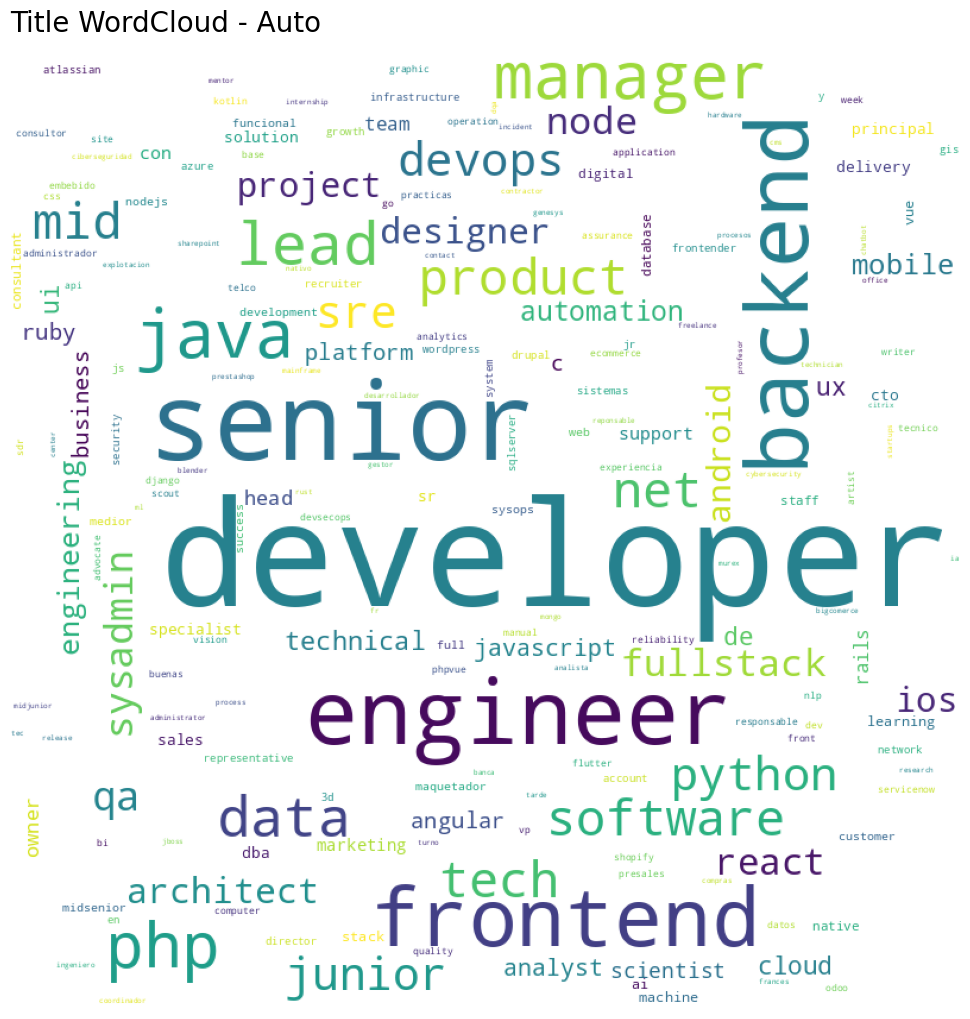

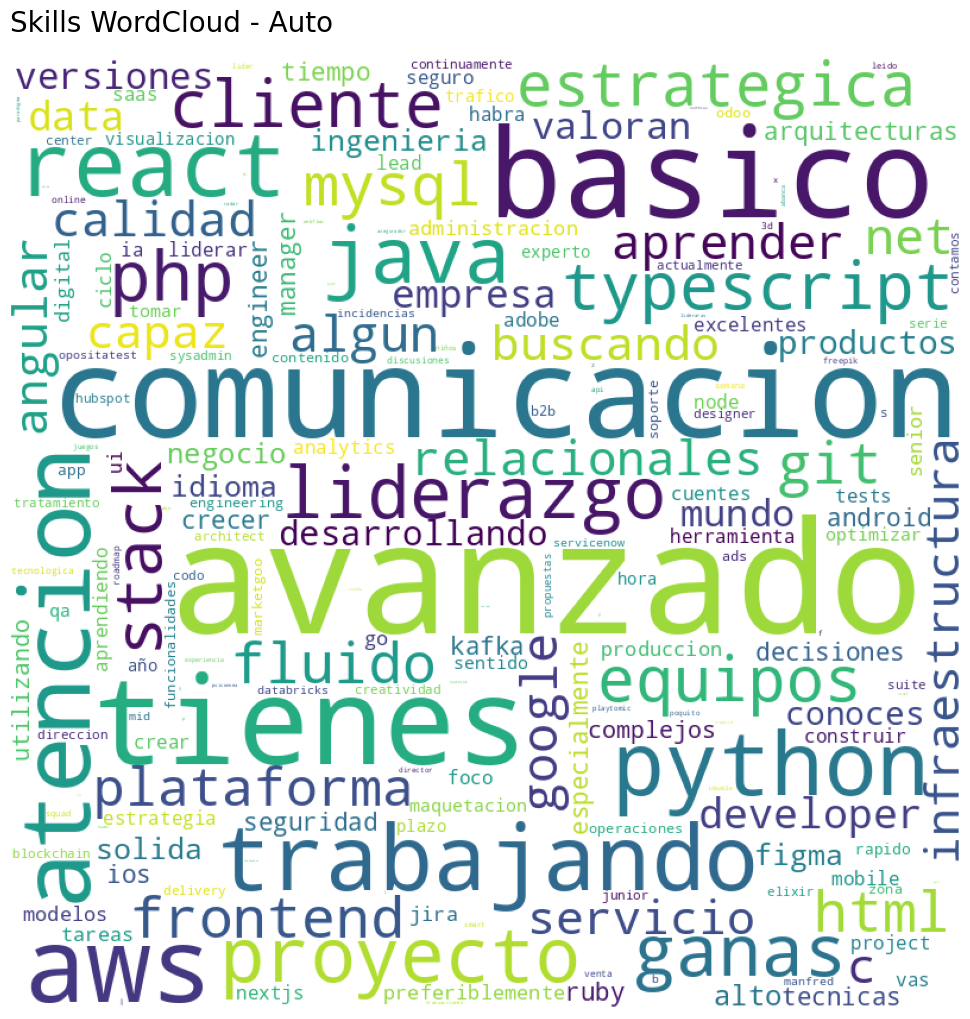

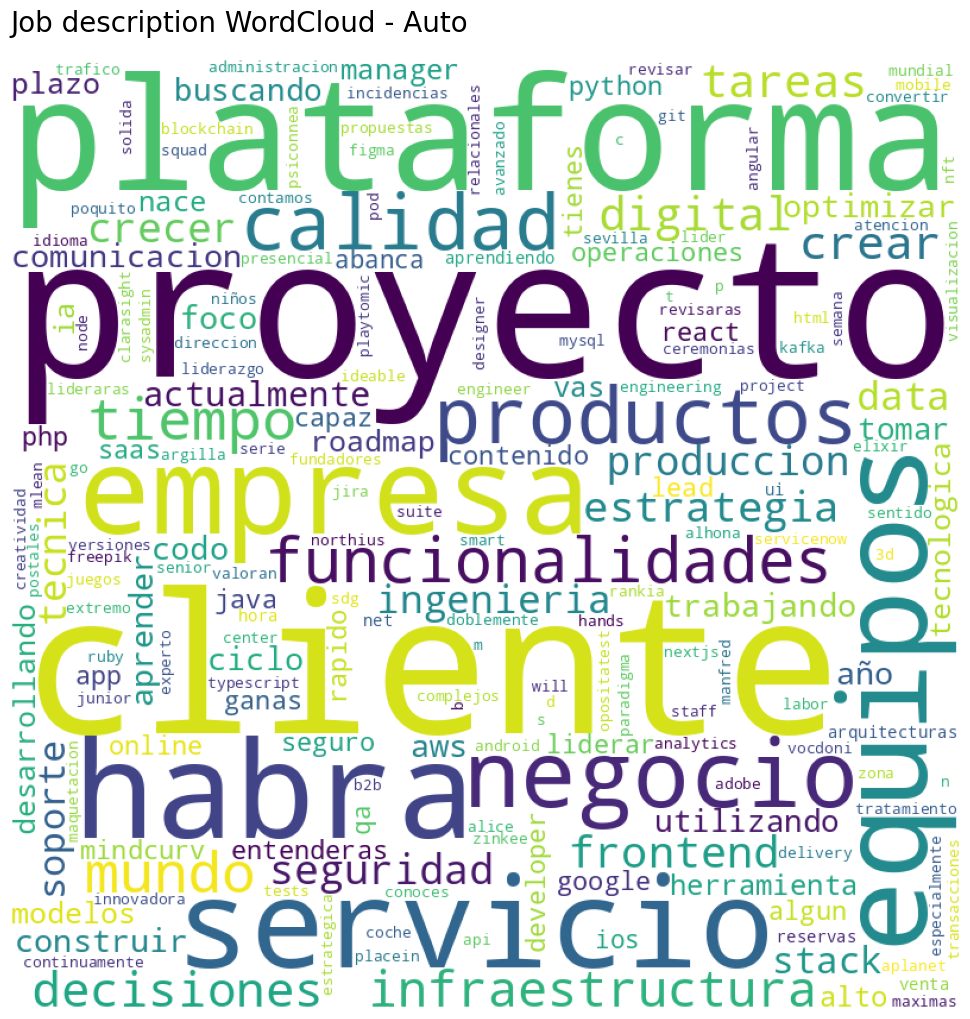

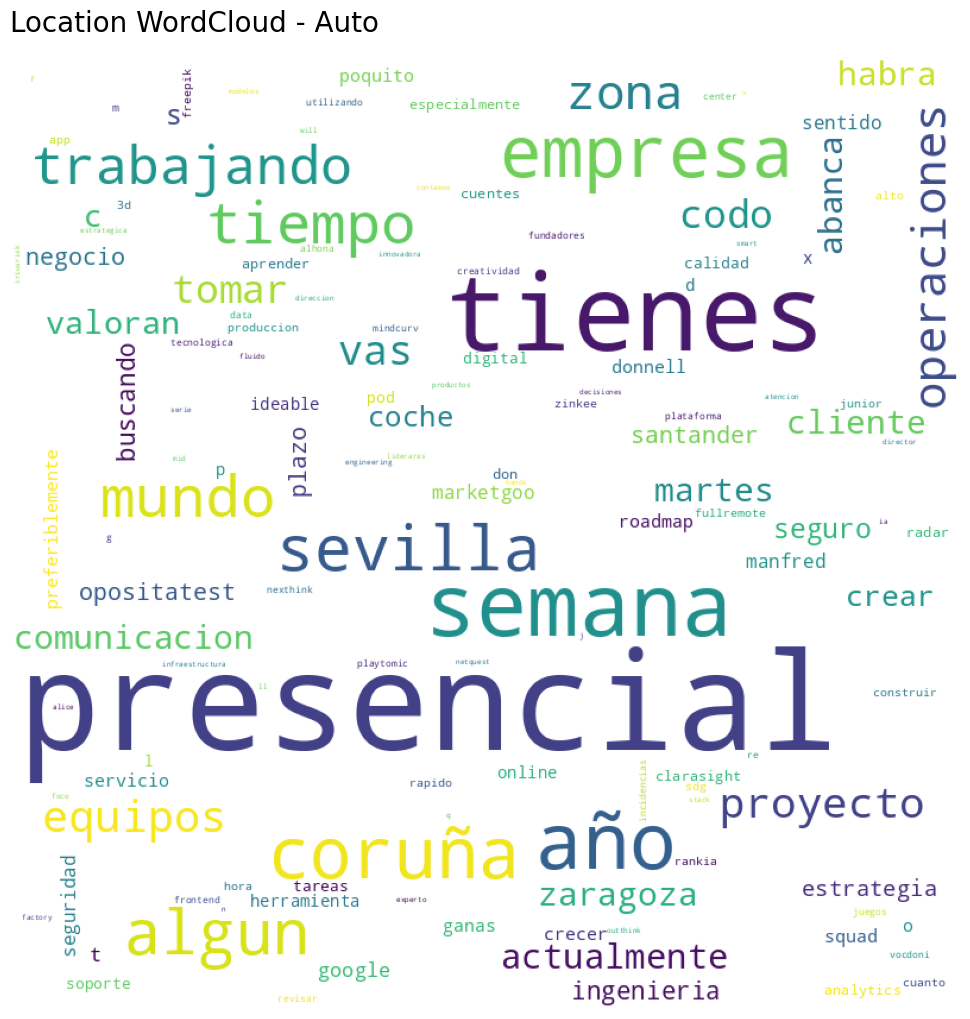

In [ ]:
# --- WORDCLOUD de titulos ---
wordcloud = WordCloud(width=800, height=800,
                      background_color="white",
                      min_font_size=2, collocations=False).generate(prepare_wordcloud_corpus(df_offers_es['title_clean']))

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.title("Title WordCloud - Auto", loc="left", fontsize=20, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

print()

# --- WORDCLOUD de skills ---
wordcloud = WordCloud(width=800, height=800,
                      background_color="white",
                      min_font_size=2, collocations=False).generate(prepare_wordcloud_corpus(df_offers_es['skills_clean_auto']))

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.title("Skills WordCloud - Auto", loc="left", fontsize=20, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

print()

# --- WORDCLOUD de job_description ---
wordcloud = WordCloud(width=800, height=800,
                      background_color="white",
                      min_font_size=2, collocations=False).generate(prepare_wordcloud_corpus(df_offers_es['job_description_clean_auto']))

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.title("Job description WordCloud - Auto", loc="left", fontsize=20, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

print()

# --- WORDCLOUD de location ---
wordcloud = WordCloud(width=800, height=800,
                      background_color="white",
                      min_font_size=2, collocations=False).generate(prepare_wordcloud_corpus(df_offers_es['location_clean_auto']))

plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor='blue')
plt.title("Location WordCloud - Auto", loc="left", fontsize=20, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
# Definir modelos de regresión
regression_models = {
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42),
    "Lasso": Lasso(alpha=0.1)
}

# Evaluar con todos los vectorizadores
all_results0 = evaluate_all_vectorizers(
    regression_models,
    df_offers_es["full_description_clean_auto"],
    df_offers_es['salary_int'],
    problem_type='regression'
)


Evaluando 4 modelos con 5 métodos de vectorización

Método: TFIDF
----------------------------------------
  Entrenando Ridge... Completado en 0.01s - r2: 0.5805, mse: 117.5145, mae: 6.7421
  Entrenando RandomForest... Completado en 11.42s - r2: 0.5064, mse: 138.2596, mae: 7.3219
  Entrenando XGBoost... Completado en 3.06s - r2: 0.5771, mse: 118.4694, mae: 7.1517
  Entrenando Lasso... Completado en 0.01s - r2: 0.2282, mse: 216.2121, mae: 9.3487
Tiempo total método tfidf: 14.58 segundos

Método: BOW
----------------------------------------
  Entrenando Ridge... Completado en 0.04s - r2: 0.7024, mse: 83.3598, mae: 6.3402
  Entrenando RandomForest... Completado en 9.14s - r2: 0.5179, mse: 135.0364, mae: 7.0534
  Entrenando XGBoost... Completado en 0.27s - r2: 0.5923, mse: 114.2063, mae: 6.9175
  Entrenando Lasso... Completado en 0.04s - r2: 0.6162, mse: 107.5162, mae: 6.7418
Tiempo total método bow: 9.55 segundos

Método: WORD2VEC
----------------------------------------
  Entrenando mod

In [ ]:
# Mostrar resultados ordenados por R²
print("\nResultados completos ordenados por R²:")
print(all_results0.sort_values(by='r2', ascending=False))


Resultados completos ordenados por R²:
           model vectorization        r2         mse        mae
4          Ridge           bow  0.702422   83.359831   6.340221
7          Lasso           bow  0.616188  107.516244   6.741837
6        XGBoost           bow  0.592306  114.206291   6.917524
0          Ridge         tfidf  0.580496  117.514500   6.742121
2        XGBoost         tfidf  0.577087  118.469360   7.151664
5   RandomForest           bow  0.517946  135.036360   7.053440
1   RandomForest         tfidf  0.506440  138.259555   7.321944
12         Ridge      fasttext  0.414652  163.971961   8.395284
16         Ridge       doc2vec  0.407576  165.954162   8.934059
13  RandomForest      fasttext  0.406479  166.261513   8.390871
18       XGBoost       doc2vec  0.400552  167.921602   8.768562
14       XGBoost      fasttext  0.380515  173.534555   8.716895
17  RandomForest       doc2vec  0.374171  175.311745   9.007450
9   RandomForest      word2vec  0.331427  187.285484   9.194168
